In [1]:
import sys 
sys.path.append('../src') 
import numpy as np
#for some reason, matplotlib crashes without these lines
a = np.zeros((5,5))
a@a
import matplotlib.pyplot as plt
from utils import get_mesh_vtk
from utils import get_data
from utils import strip_cross, reconstruct_cross
from KPCA import *
import KPCA
import Autoencoder
# from torchsummary import summary
# from Autoencoder import Autoencoder
import torch
import torch.nn as nn
from utils import calc_energy, torch2np
import glob
import os
# from importlib import reload

In [2]:
def read_from_ds(Wi, beta, ds_path=None):
    if ds_path is None:
        ds_path = '../npz_data/crossTurb_train'

    files = glob.glob(f'*Wi{Wi:g}_beta{beta:g}*.pt', root_dir=ds_path)
    X = torch.load(f'{ds_path}/{files[0]}')['tensor']
    data = torch.zeros([len(files)] + [s for s in X.shape])
    for i,file in enumerate(files):
        data[i] = torch.load(f'{ds_path}/{file}')['tensor']
    return data

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [3]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)

In [5]:
# Read the meshgrid for computing the energy

vtk_file = '../../npz_data/Dados-N0.vtk'
x, y = get_mesh_vtk(vtk_file)
cut = 13 # removes the influence of inflow/outflow
dx = x[1:] - x[:-1]
dy = y[1:] - y[:-1]
DX, DY = np.meshgrid(dx,dy)
DX = strip_cross(DX[...,None,None], cut).squeeze()
DY = strip_cross(DY[...,None,None], cut).squeeze()

xc = (x[1:] + x[:-1])/2
yc = (y[1:] + y[:-1])/2
X_mesh, Y_mesh = np.meshgrid(xc,yc)
X_mesh = strip_cross(X_mesh[...,None,None], cut).squeeze()
Y_mesh = strip_cross(Y_mesh[...,None,None], cut).squeeze()

Xr_mesh = reconstruct_cross(X_mesh[:,None, None], cut).squeeze()
Yr_mesh = reconstruct_cross(Y_mesh[:,None, None], cut).squeeze()

Xr_mesh[:65-cut,:65-cut] = 11
Xr_mesh[-65+cut:,:65-cut] = 11
Xr_mesh[:65-cut,-65+cut:] = 11
Xr_mesh[-65+cut:,-65+cut:] = 11

Yr_mesh[:65-cut,:65-cut] = 11
Yr_mesh[-65+cut:,:65-cut] = 11
Yr_mesh[:65-cut,-65+cut:] = 11
Yr_mesh[-65+cut:,-65+cut:] = 11

In [6]:
# NN part
small = True # Use less parameter in the architechture

latent_dim = 3
autoencoder = Autoencoder.ParametricVAEModule(n_input= DX.shape[0], latent_dim = latent_dim, max_in=torch.zeros((1,5,1)), min_in=torch.zeros((1,5,1)), small = True).to(device)
if small:
    autoencoder.load_state_dict(torch.load(f'../../Models/VAE_CrossParametric_Latent_{latent_dim}_small/best_autoencoder',map_location=torch.device('cpu')))
else:
    autoencoder.load_state_dict(torch.load(f'../../Models/VAE_CrossParametric_Latent_{latent_dim}_reg/best_autoencoder',map_location=torch.device('cpu')))

print(get_n_params(autoencoder))

56397127


In [7]:
Re = 0.01
# Parameters:
parameters = [
        (0.8, 0.11111), # Outlier
        (2.5, 0.11111), # 1
        (2.5, 0.22222), # 2
        (2.5, 0.33333), # 3
        (2.5, 0.44444), # 4
        (3.0, 0.11111), # 5
        (3.0, 0.22222), # 6
        (3.5, 0.11111), # 7
        (3.5, 0.22222), # 8
        (3.5, 0.33333), # 9
        (4.0, 0.33333), # 10
        (4.5, 0.11111), # 11
        (4.5, 0.22222), # 12
        (4.5, 0.33333), # 13
        (5.0, 0.11111), # 14
        (5.0, 0.22222), # 15
        (5.0, 0.33333), # 16
        (5.5, 0.11111), # 17
        (5.5, 0.33333), # 18
        (6.0, 0.22222), # 19
        (6.0, 0.44444), # 20
        (6.5, 0.11111), # 21
        (6.5, 0.33333), # 22
        (7.0, 0.11111), # 23
        (7.0, 0.22222), # 24
        (7.0, 0.44444), # 25
        (7.5, 0.11111), # 26
        # test
        (4.0, 0.22222), # -2 (27)
        (7.5, 0.33333)  # -1 (28)
]


In [7]:
Xpca = np.zeros((66045,0))
Parampca = np.zeros((0,2))
training_index = range(1,27,3)
for i in training_index:
# for i in [1,2, 4]:
    Wi_temp ,beta_temp = parameters[i]
    params_temp = np.array([Wi_temp, beta_temp])

    X_temp = read_from_ds(*params_temp, ds_path='../npz_data/crossTurb_train')
    Xt = torch2np(X_temp)
    param_temp = np.zeros((X_temp.shape[0], 2))
    param_temp[:] = params_temp

    Xpca = np.concatenate((Xpca,Xt), axis=1)
    Parampca = np.concatenate((Parampca,param_temp), axis=0)

print("Train PCA Shape",Xpca.shape)
print('Params Train Shape',Parampca.shape)
print('Training indexes:', [i for i in training_index])

Wi_arr = Parampca[:,0]
beta_arr = Parampca[:,1]

theta_pca = ((1-beta_arr)/(Re * Wi_arr))[:,None]
theta_pca_sqrt = np.sqrt(theta_pca@theta_pca.T)

print('Theta Shape',theta_pca.shape)
print('Theta train Shape',theta_pca_sqrt.shape)

Train PCA Shape (66045, 8991)
Params Train Shape (8991, 2)
Training indexes: [1, 4, 7, 10, 13, 16, 19, 22, 25]
Theta Shape (8991, 1)
Theta train Shape (8991, 8991)


In [8]:
KPCA_linear = KPCA.KernelPCA()
KPCA_oldroyd = KPCA.KernelPCA()

KPCA_linear.load_model('../KPCA_linear.npz')
KPCA_oldroyd.load_model('../KPCA_oldroyd.npz')

KPCA_linear.degree = 1
KPCA_oldroyd.degree = 1

KPCA_linear.thetas_fit = theta_pca.T
KPCA_oldroyd.thetas_fit = theta_pca.T

KPCA_linear.center = True
KPCA_oldroyd.center = True



In [20]:
center = False

KPCA_linear.train_R(1, center, n_components=latent_dim)
KPCA_oldroyd.train_R(1, center, n_components=latent_dim)

In [34]:
KPCA_oldroyd.train_R(1, False, n_components=20)

In [ ]:
degree = 1
ncomp = latent_dim 

KPCA_linear = KPCA.KernelPCA()
KPCA_oldroyd = KPCA.KernelPCA()

KPCA_linear.fit(Xpca.T, n_components=ncomp, kernel='linear', theta=theta_pca_sqrt, norm='DIV', eps = None, degree = degree)
KPCA_oldroyd.fit(Xpca.T, n_components=ncomp, kernel='oldroyd', theta=theta_pca_sqrt, norm='DIV', eps = None, dx = DX[None,:], dy = DY[None,:], degree = degree)


In [9]:

## Data reading
ind = 1
Wi ,beta = parameters[ind]
params = [Wi, beta]

if (ind < 0 and ind > -3) or ind > 26:
    dspath = '../../npz_data/crossTurb_test'
else:
    dspath = '../../npz_data/crossTurb_train'

X_torch = read_from_ds(*params, ds_path=dspath)
X = torch2np(X_torch)
param = torch.ones((X_torch.shape[0], 2)).float()
param[:] = torch.Tensor(params).float()


Wi_data = param[:,0].numpy()
beta_data = param[:,1].numpy()

theta_data = ((1-beta_data)/(Re * Wi_data))[:,None]

print('Data shape: ',X.shape)
print('theta shape: ',theta_data.shape)
print('theta: ',theta_data[0])

Data shape:  (66045, 999)
theta shape:  (999, 1)
theta:  [35.555603]


In [10]:
# Run test
with torch.no_grad():
    code, _, _ = autoencoder.encode(X_torch, param)
    X_ae_torch= autoencoder.decode(code, param)
    # X_ae_torch,_,_ = autoencoder(X_torch.float(), param.float())
X_ae = torch2np(X_ae_torch)

In [12]:
code[:-1].shape

torch.Size([998, 3])

In [41]:
# theta = np.sqrt(theta_data@theta_pca.T)

phi_linear  = KPCA_linear.transform( X.T, theta = theta_data, eps = None)
phi_oldroyd = KPCA_oldroyd.transform(X.T, theta = theta_data, eps = None,dx = DX[None,:], dy = DY[None,:])

# X_linear  = KPCA_linear.invert_transform(phi_linear,theta = theta_data.T)
# X_oldroyd = KPCA_oldroyd.invert_transform(phi_oldroyd,theta = theta_data.T)

In [27]:
def invert_transform(Phi, theta, R, degree = 1):
    Phi_ext = np.concatenate([np.ones((Phi.shape[0],1))] +[np.ones((Phi.shape[0],1))  / np.sqrt(theta).T]  + [Phi**(k+1) for k in range(degree)]+ [(Phi / np.sqrt(theta).T)**(k+1) for k in range(degree)], axis=1)
    #reconstruction
    X = R@Phi_ext.T
    return X

In [42]:
X_linear  = invert_transform(phi_linear,theta = theta_data.T, R = KPCA_linear.R, degree = KPCA_linear.degree)
X_oldroyd = invert_transform(phi_oldroyd,theta = theta_data.T, R = KPCA_oldroyd.R, degree = KPCA_oldroyd.degree)

In [43]:
# Energy From data
elastic, kinetic, total = calc_energy(X,Wi,beta,Re, dx = DX[:,None], dy = DY[:,None])

# # Energy From Autoencoder
elastic_ae, kinetic_ae, total_ae = calc_energy(X_ae,Wi,beta,Re,dx = DX[:,None], dy = DY[:,None])

# Energy From PCA
elastic_linear, kinetic_linear, total_linear = calc_energy(X_linear,Wi,beta,Re,dx = DX[:,None], dy = DY[:,None])
# Energy From KPCA
elastic_oldroyd, kinetic_oldroyd, total_oldroyd = calc_energy(X_oldroyd,Wi,beta,Re,dx = DX[:,None], dy = DY[:,None])
# elastic_oldroyd_2, kinetic_oldroyd_2, total_oldroyd_2 = calc_energy(X_oldroyd *tsm/theta_data[0,0],Wi,beta,Re,dx = DX[:,None], dy = DY[:,None])

In [18]:
KPCA_oldroyd.R.shape, X_oldroyd.shape, phi_oldroyd.shape

((66045, 7), (66045, 999), (999, 3))

In [24]:
66045//5

13209

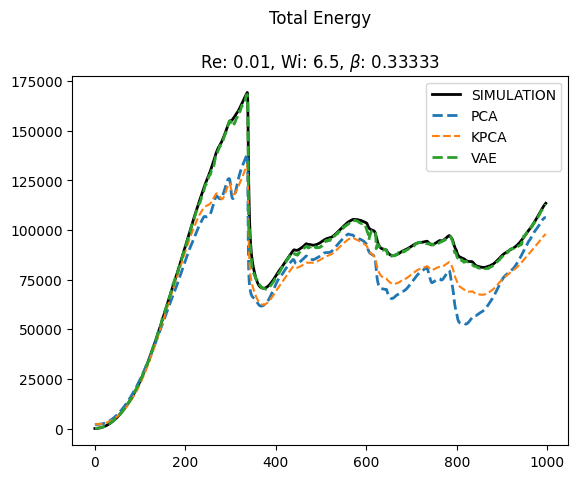

In [38]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)

plt.plot(total_linear[ini:fim],'--', label = 'PCA', lw = lw)
plt.plot(total_oldroyd[ini:fim],'--', label = 'KPCA')
# plt.plot(total_oldroyd_2[ini:fim],'--', label = 'KPCA 2')

plt.plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
plt.title(f'Total Energy\n\nRe: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()

# plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

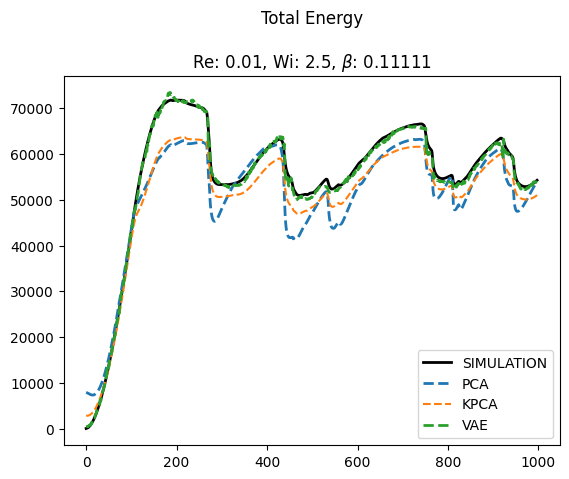

In [44]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)

plt.plot(total_linear[ini:fim],'--', label = 'PCA', lw = lw)
plt.plot(total_oldroyd[ini:fim],'--', label = 'KPCA')
# plt.plot(total_oldroyd_2[ini:fim],'--', label = 'KPCA 2')

plt.plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
plt.title(f'Total Energy\n\nRe: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()

# plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

In [45]:
# Reconstruction Error:
norm_x = np.linalg.norm(X)
err_ae = np.linalg.norm(X - X_ae)/norm_x
err_linear = np.linalg.norm(X - X_linear)/norm_x
err_oldroyd = np.linalg.norm(X - X_oldroyd)/norm_x

print(f'Relative error VAE: {err_ae:g}')
print(f'Relative error PCA: {err_linear:g}')
print(f'Relative error KPCA: {err_oldroyd:g}')

Relative error VAE: 0.112412
Relative error PCA: 0.340636
Relative error KPCA: 0.332425


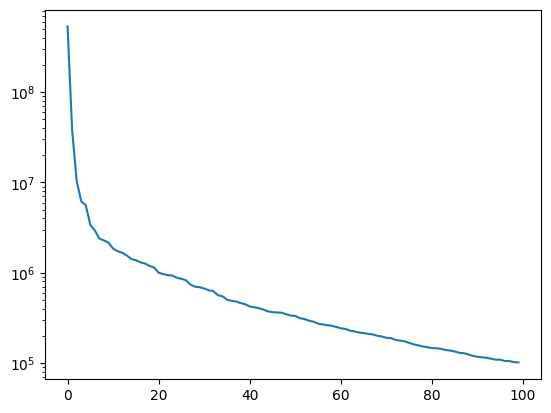

In [52]:
eigenvalues, eigenvectors = np.linalg.eigh(KPCA_oldroyd.K_fit)
# Sort eigenvalues and eigenvectors in descending order
indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[indices]
plt.plot(eigenvalues[:100])
plt.yscale('log')

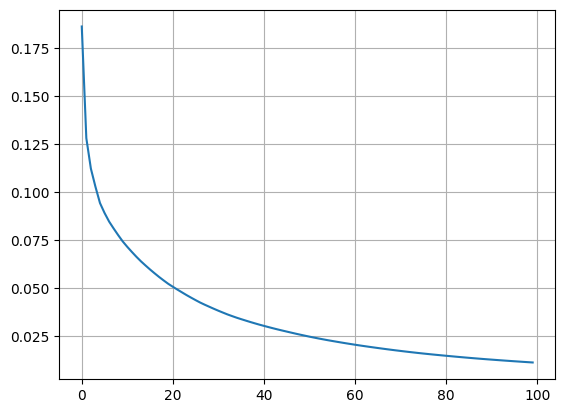

In [55]:
seig = 1 - np.cumsum(eigenvalues)/eigenvalues.sum()

plt.plot(seig[:100])
# plt.yscale('log')
plt.grid()

In [46]:
# Reconstruction Error:
energy_norm_x = np.abs(total).sum()
energy_err_ae = np.abs(total - total_ae).sum()/energy_norm_x
energy_err_linear = np.abs(total - total_linear).sum()/energy_norm_x
energy_err_oldroyd = np.abs(total - total_oldroyd).sum()/energy_norm_x

print(f'Rel. energy error VAE: {energy_err_ae:g}')
print(f'Rel. energy error PCA: {energy_err_linear:g}')
print(f'Rel. energy error KPCA: {energy_err_oldroyd:g}')

Rel. energy error VAE: 0.0101553
Rel. energy error PCA: 0.0856229
Rel. energy error KPCA: 0.0747772


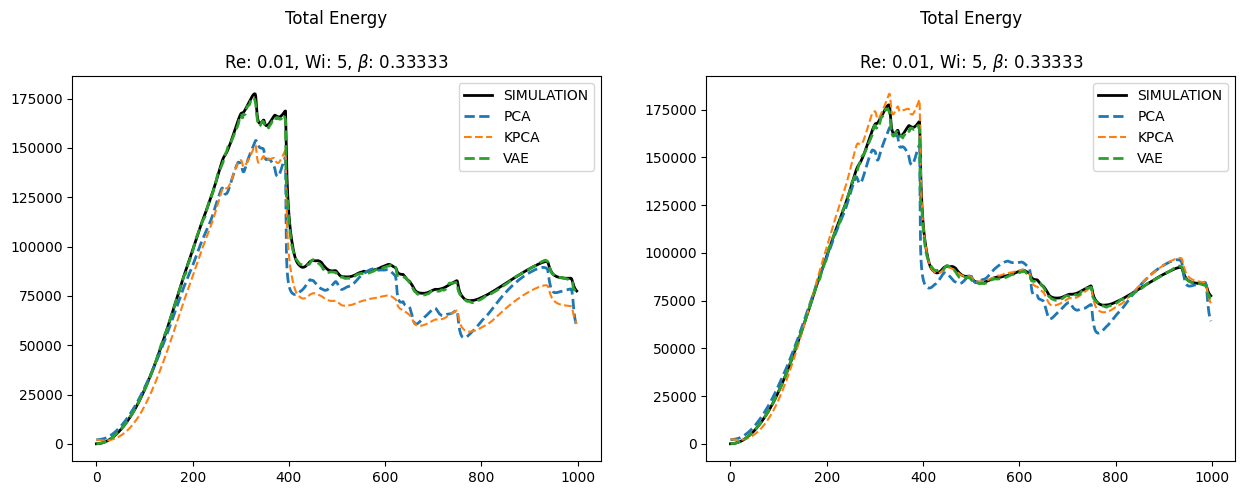

In [81]:
ini = 0
fim = 999
lw = 2

f, ax = plt.subplots(1,2, figsize = (15,5))
# True Plot
ax[0].plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)

ax[0].plot(total_linear[ini:fim],'--', label = 'PCA', lw = lw)
ax[0].plot(total_oldroyd[ini:fim],'--', label = 'KPCA')

ax[0].plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
ax[0].set_title(f'Total Energy\n\nRe: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
ax[0].legend()
# Scaled plot
fat_lin = (total/total_linear).mean()
fat_old = (total/total_oldroyd).mean()
ax[1].plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)

ax[1].plot(total_linear[ini:fim] * fat_lin,'--', label = 'PCA', lw = lw)
ax[1].plot(total_oldroyd[ini:fim] * fat_old,'--', label = 'KPCA')

ax[1].plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
ax[1].set_title(f'Total Energy\n\nRe: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
ax[1].legend()

# plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

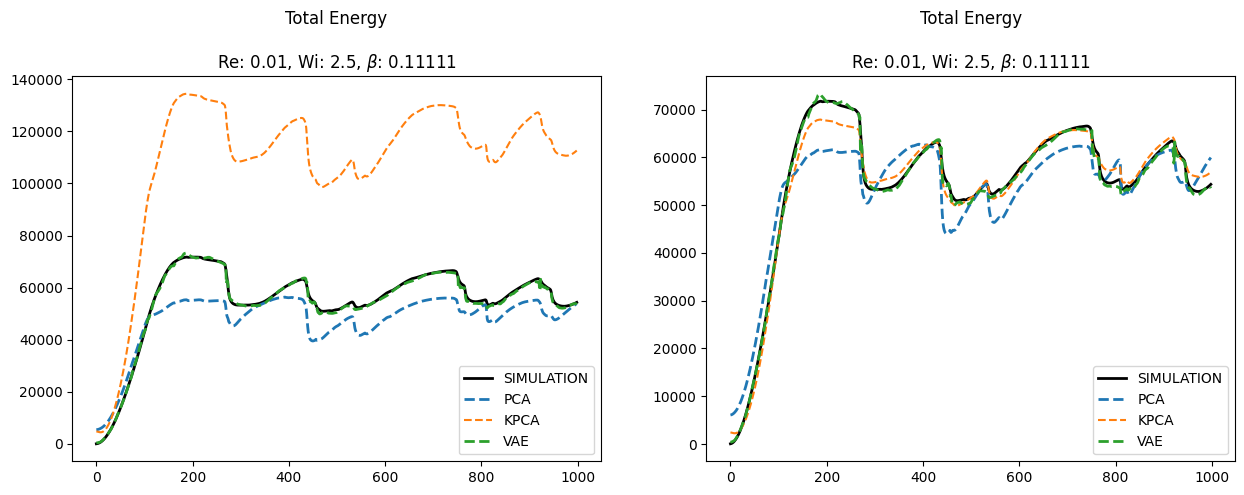

In [60]:
ini = 0
fim = 999
lw = 2

f, ax = plt.subplots(1,2, figsize = (15,5))
# True Plot
ax[0].plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)

ax[0].plot(total_linear[ini:fim],'--', label = 'PCA', lw = lw)
ax[0].plot(total_oldroyd[ini:fim],'--', label = 'KPCA')

ax[0].plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
ax[0].set_title(f'Total Energy\n\nRe: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
ax[0].legend()
# Scaled plot
fat_lin = (total/total_linear).mean()
fat_old = (total/total_oldroyd).mean()
ax[1].plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)

ax[1].plot(total_linear[ini:fim] * fat_lin,'--', label = 'PCA', lw = lw)
ax[1].plot(total_oldroyd[ini:fim] * fat_old,'--', label = 'KPCA')

ax[1].plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
ax[1].set_title(f'Total Energy\n\nRe: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
ax[1].legend()

# plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

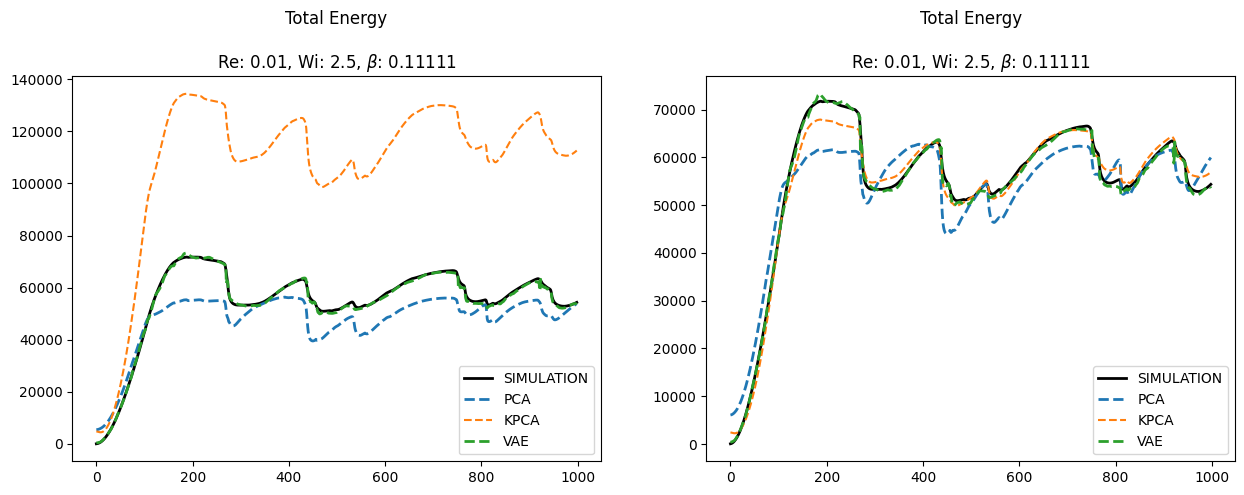

In [104]:
ini = 0
fim = 999
lw = 2

f, ax = plt.subplots(1,2, figsize = (15,5))
# True Plot
ax[0].plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)

ax[0].plot(total_linear[ini:fim],'--', label = 'PCA', lw = lw)
ax[0].plot(total_oldroyd[ini:fim],'--', label = 'KPCA')

ax[0].plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
ax[0].set_title(f'Total Energy\n\nRe: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
ax[0].legend()
# Scaled plot
fat_lin = (total/total_linear).mean()
fat_old = (total/total_oldroyd).mean()
ax[1].plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)

ax[1].plot(total_linear[ini:fim] * fat_lin,'--', label = 'PCA', lw = lw)
ax[1].plot(total_oldroyd[ini:fim] * fat_old,'--', label = 'KPCA')

ax[1].plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
ax[1].set_title(f'Total Energy\n\nRe: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
ax[1].legend()

# plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

In [123]:
filename = '../KPCA_linear.npz'
np.savez_compressed(filename, eigvec = KPCA_linear.normalized_eigenvector, eigvalue = KPCA_linear.eigenvalues, K = KPCA_linear.K_fit, X = KPCA_linear.X_fit, kernel = KPCA_linear.kernel, U = KPCA_linear.U_fit, R = KPCA_linear.R)
filename = '../KPCA_oldroyd.npz'
np.savez_compressed(filename, eigvec = KPCA_oldroyd.normalized_eigenvector, eigvalue = KPCA_oldroyd.eigenvalues, K = KPCA_oldroyd.K_fit, X = KPCA_oldroyd.X_fit, kernel = KPCA_oldroyd.kernel, U = KPCA_oldroyd.U_fit, R = KPCA_oldroyd.R)

In [105]:
KPCA_linear.save_model('../KPCA_linear.npz')
KPCA_oldroyd.save_model('../KPCA_oldroyd.npz')

In [156]:
## Visual Plots
X_rec = reconstruct_cross(X_ae.reshape((-1,5,999)), cut)
X_rec[:65-cut,:65-cut] = np.NaN
X_rec[-65+cut:,:65-cut] = np.NaN
X_rec[:65-cut,-65+cut:] = np.NaN
X_rec[-65+cut:,-65+cut:] = np.NaN

X_rec_lin = reconstruct_cross(X_linear.reshape((-1,5,999)), cut)
X_rec_lin[:65-cut,:65-cut] = np.NaN
X_rec_lin[-65+cut:,:65-cut] = np.NaN
X_rec_lin[:65-cut,-65+cut:] = np.NaN
X_rec_lin[-65+cut:,-65+cut:] = np.NaN

X_rec_old = reconstruct_cross(X_oldroyd.reshape((-1,5,999)), cut)
X_rec_old[:65-cut,:65-cut] = np.NaN
X_rec_old[-65+cut:,:65-cut] = np.NaN
X_rec_old[:65-cut,-65+cut:] = np.NaN
X_rec_old[-65+cut:,-65+cut:] = np.NaN

X_true = reconstruct_cross(X.reshape((-1,5,999)), cut)
X_true[:65-cut,:65-cut] = np.NaN
X_true[-65+cut:,:65-cut] = np.NaN
X_true[:65-cut,-65+cut:] = np.NaN
X_true[-65+cut:,-65+cut:] = np.NaN

tra_Ar = X_rec[...,2,:]**2 + X_rec[...,4,:]**2 + 2* X_rec[...,3,:]**2
tra_Ar_lin = X_rec_lin[...,2,:]**2 + X_rec_lin[...,4,:]**2 + 2* X_rec_lin[...,3,:]**2
tra_Ar_old = X_rec_old[...,2,:]**2 + X_rec_old[...,4,:]**2 + 2* X_rec_old[...,3,:]**2
tra_At = X_true[...,2,:]**2 + X_true[...,4,:]**2 + 2* X_true[...,3,:]**2

In [58]:
save_dir = f'Images/VAE_parametric_small/Wi_{Wi:g}_beta_{beta:g}'
os.makedirs(save_dir, exist_ok= True)
for t in range(X.shape[1]):
# for t in range(1):
    vmin = np.min([np.nanmin(tra_At[...,t]), np.nanmin(tra_Ar[...,t]), np.nanmin(tra_Ar_lin[...,t]), np.nanmin(tra_Ar_old[...,t])])
    vmax = np.max([np.nanmax(tra_At[...,t]), np.nanmax(tra_Ar[...,t]), np.nanmax(tra_Ar_lin[...,t]), np.nanmax(tra_Ar_old[...,t])])
    levels = np.linspace(vmin, vmax, 50)
    f, ax = plt.subplots(2,2, figsize = (10,12))

    ax[0,0].contourf(Xr_mesh,Yr_mesh,tra_At[...,t], levels=levels)
    ax[1,0].contourf(Xr_mesh,Yr_mesh,tra_Ar_lin[...,t], levels=levels)

    ax[0,0].set_title('Simulation')
    ax[1,0].set_title('PCA')

    surf = ax[0,1].contourf(Xr_mesh,Yr_mesh,tra_Ar[...,t], levels=levels)
    ax[1,1].contourf(Xr_mesh,Yr_mesh,tra_Ar_old[...,t], levels=levels)
    ax[0,1].set_title('VAE')
    ax[1,1].set_title('KPCA')
    f.suptitle(f'Trace of Conformation\nRe: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}\nt = {t*4e-2:g}')
    ax[0,0].set_xticks([])
    ax[1,0].set_xticks([])
    ax[0,0].set_yticks([])
    ax[1,0].set_yticks([])
    ax[0,1].set_xticks([])
    ax[1,1].set_xticks([])
    ax[0,1].set_yticks([])
    ax[1,1].set_yticks([])
    f.tight_layout()
    plt.colorbar(surf, ax = ax, location='bottom')
    f.savefig(f'{save_dir}/frame_{t}.png')
    plt.close()
    

In [59]:
video_cmd = f'ffmpeg -framerate 25 -i frame_%d.png -c:v libx264 -r 30 -pix_fmt yuv420p Wi{Wi:g}_beta{beta:g}.mp4'
video_cmd

'ffmpeg -framerate 25 -i frame_%d.png -c:v libx264 -r 30 -pix_fmt yuv420p Wi4_beta0.22222.mp4'

In [10]:
def normal_dist(x,u=0,s=1):
    sqrt_2pi = np.sqrt(2*np.pi)
    return np.exp(-.5 * ((x-u)/s)**2) / (s * sqrt_2pi)

In [55]:
## Data reading
ind = 1
Wi ,beta = parameters[ind]
params = [Wi, beta]

if (ind < 0 and ind > -3) or ind > 26:
    dspath = '../npz_data/crossTurb_test'
else:
    dspath = '../npz_data/crossTurb_train'

X_torch = read_from_ds(*params, ds_path=dspath)
X = torch2np(X_torch)
param = torch.ones((X_torch.shape[0], 2)).float()
param[:] = torch.Tensor(params).float()


Wi_data = param[:,0].numpy()
beta_data = param[:,1].numpy()

theta_data = ((1-beta_data)/(Re * Wi_data))[:,None]

print('Data shape: ',X.shape)
print('theta shape: ',theta_data.shape)
print('theta: ',theta_data[0])

Data shape:  (66045, 999)
theta shape:  (999, 1)
theta:  [35.555603]


In [50]:
snap = 150

with torch.no_grad():
    _, u, s = autoencoder.encode(X_torch[snap:snap+1], param[snap:snap+1])

    u = u.numpy().flatten()
    s = s.numpy().flatten()
    s = np.exp(s)

2.0
2.0
2.0


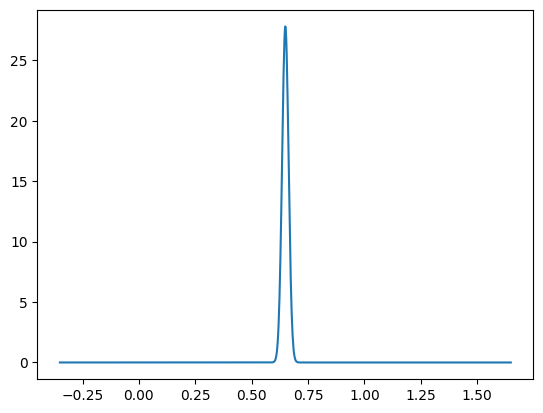

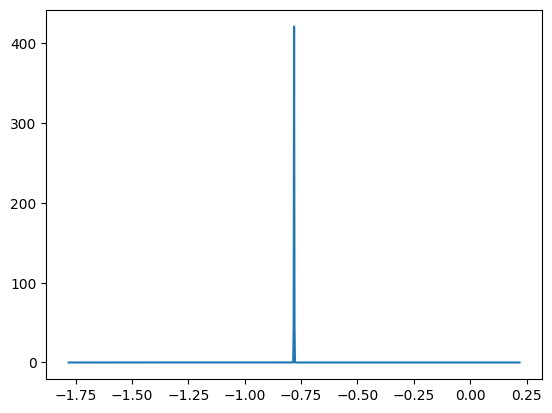

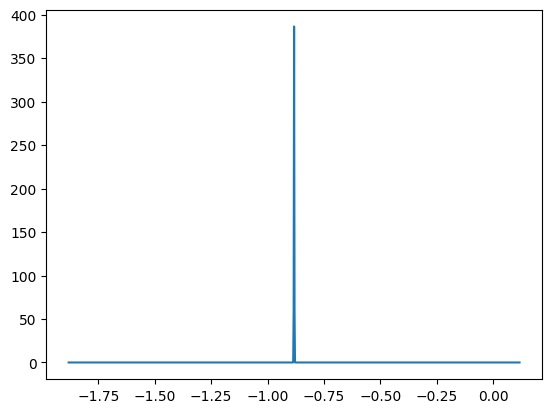

In [51]:
for ui, si in zip(u,s):
    r = np.maximum(1,6*si)
    x = np.linspace(ui- r, ui+r, 1001)

    y = normal_dist(x,ui,si)

    plt.figure()
    plt.plot(x,y)
    print(np.ptp(x))

In [9]:
theta_data.shape, theta_pca.shape

((999, 1), (8991, 1))

In [10]:
theta_pca.mean(), np.sqrt((theta_data@theta_pca.T)).mean()

(17.68288099986433, 12.230369048993284)

In [138]:

## Data reading
def rec_kpca(ind, min_energy = False):
    Wi ,beta = parameters[ind]
    params = [Wi, beta]

    if (ind < 0 and ind > -3) or ind > 26:
        dspath = '../npz_data/crossTurb_test'
    else:
        dspath = '../npz_data/crossTurb_train'

    X_torch = read_from_ds(*params, ds_path=dspath)
    X = torch2np(X_torch)
    param = torch.ones((X_torch.shape[0], 2)).float()
    param[:] = torch.Tensor(params).float()


    Wi_data = param[:,0].numpy()
    beta_data = param[:,1].numpy()

    theta_data = ((1-beta_data)/(Re * Wi_data))[:,None]

    phi_oldroyd = KPCA_oldroyd.transform(X.T, theta = theta_data, eps = None,dx = DX[None,:], dy = DY[None,:])

    X_oldroyd = KPCA_oldroyd.invert_transform(phi_oldroyd )

    if min_energy:
        _, _, total = calc_energy(X,Wi,beta,Re, dx = DX[:,None], dy = DY[:,None])
        _, _, total_oldroyd_fixed = calc_energy(X_oldroyd,Wi,beta,Re,dx = DX[:,None], dy = DY[:,None])
        # scale,_,_,_ = np.linalg.lstsq(X_oldroyd.flatten()[:, None],X.flatten(), rcond=-1) # better fit the reconstruction
        scale,_,_,_ = np.linalg.lstsq(total_oldroyd_fixed.flatten()[:, None],total.flatten(), rcond=-1) # better fit the energy
        scale = np.sqrt(scale)
    else:
        scale,_,_,_ = np.linalg.lstsq(X_oldroyd.flatten()[:, None],X.flatten(), rcond=-1) # better fit the reconstruction


    print(theta_data[0,0], scale)

In [135]:
for i in range(len(parameters)):
    rec_kpca(i)

111.11125 [0.44739147]
35.555603 [0.688996]
31.111202 [0.72845832]
26.6668 [0.77714122]
22.2224 [0.83957797]
29.62967 [0.74675721]
25.926 [0.77121213]
25.396858 [0.78762149]
22.222286 [0.81937376]
19.047712 [0.91405038]
16.66675 [0.93639996]
19.753113 [0.87706498]
17.284 [0.93922438]
14.814889 [0.98825386]
17.777802 [0.92430768]
15.555601 [0.95507348]
13.3334 [1.03637576]
16.161636 [0.97593744]
12.121272 [1.08603609]
12.963 [1.05366578]
9.259334 [1.27005718]
13.675232 [1.04033787]
10.256461 [1.16888919]
12.698429 [1.10558847]
11.111143 [1.172077]
7.936571 [1.38045221]
11.851868 [1.11306731]
19.4445 [0.88286104]
8.888933 [1.25976608]


In [139]:
for i in range(len(parameters)):
    print(i, end=': ')
    rec_kpca(i, min_energy=True)

0: 111.11125 [0.42349593]
1: 35.555603 [0.71258539]
2: 31.111202 [0.76200957]
3: 26.6668 [0.79577855]
4: 22.2224 [0.86928206]
5: 29.62967 [0.78176168]
6: 25.926 [0.80362477]
7: 25.396858 [0.82166079]
8: 22.222286 [0.86344027]
9: 19.047712 [0.96819434]
10: 16.66675 [0.99181382]
11: 19.753113 [0.93383505]
12: 17.284 [1.0144385]
13: 14.814889 [1.04075902]
14: 17.777802 [0.97427688]
15: 15.555601 [1.02844991]
16: 13.3334 [1.08593698]
17: 16.161636 [1.04384308]
18: 12.121272 [1.16052001]
19: 12.963 [1.11462578]
20: 9.259334 [1.3375545]
21: 13.675232 [1.16346467]
22: 10.256461 [1.26367909]
23: 12.698429 [1.23760562]
24: 11.111143 [1.25706124]
25: 7.936571 [1.44768616]
26: 11.851868 [1.26568942]
27: 19.4445 [0.94499042]
28: 8.888933 [1.35572899]


In [261]:
result_rec = np.array([[111.11125 ,0.44739147],
[35.555603 ,0.688996],
[31.111202 ,0.72845832],
[26.6668 ,0.77714122],
[22.2224 ,0.83957797],
[29.62967 ,0.74675721],
[25.926 ,0.77121213],
[25.396858 ,0.78762149],
[22.222286 ,0.81937376],
[19.047712 ,0.91405038],
[16.66675 ,0.93639996],
[19.753113 ,0.87706498],
[17.284 ,0.93922438],
[14.814889 ,0.98825386],
[17.777802 ,0.92430768],
[15.555601 ,0.95507348],
[13.3334 ,1.03637576],
[16.161636 ,0.97593744],
[12.121272 ,1.08603609],
[12.963 ,1.05366578],
[9.259334 ,1.27005718],
[13.675232 ,1.04033787],
[10.256461 ,1.16888919],
[12.698429 ,1.10558847],
[11.111143 ,1.172077],
[7.936571 ,1.38045221],
[11.851868 ,1.11306731],
[19.4445 ,0.88286104],
[8.888933 ,1.25976608],])

result_rec.shape

(29, 2)

In [278]:
result_energy = np.array([ [111.11125 ,0.42349593],
 [35.555603 ,0.71258539],
 [31.111202 ,0.76200957],
 [26.6668 ,0.79577855],
 [22.2224 ,0.86928206],
 [29.62967 ,0.78176168],
 [25.926 ,0.80362477],
 [25.396858 ,0.82166079],
 [22.222286 ,0.86344027],
 [19.047712 ,0.96819434],
 [16.66675 ,0.99181382],
 [19.753113 ,0.93383505],
 [17.284 ,1.0144385],
 [14.814889 ,1.04075902],
 [17.777802 ,0.97427688],
 [15.555601 ,1.02844991],
 [13.3334 ,1.08593698],
 [16.161636 ,1.04384308],
 [12.121272 ,1.16052001],
 [12.963 ,1.11462578],
 [9.259334 ,1.3375545],
 [13.675232 ,1.16346467],
 [10.256461 ,1.26367909],
 [12.698429 ,1.23760562],
 [11.111143 ,1.25706124],
 [7.936571 ,1.44768616],
 [11.851868 ,1.26568942],
 [19.4445 ,0.94499042],
 [8.888933 ,1.35572899],])
result_energy.shape

(29, 2)

In [243]:
parameters_arr = np.array(parameters)

In [246]:
parameters_arr[:,0]

array([0.8, 2.5, 2.5, 2.5, 2.5, 3. , 3. , 3.5, 3.5, 3.5, 4. , 4.5, 4.5,
       4.5, 5. , 5. , 5. , 5.5, 5.5, 6. , 6. , 6.5, 6.5, 7. , 7. , 7. ,
       7.5, 4. , 7.5])

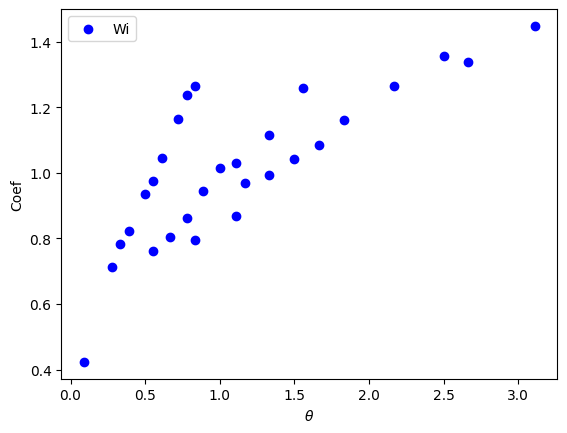

In [253]:

plt.scatter(parameters_arr[:,0]*(parameters_arr[:,1]), result_energy[:,1], c='b', label = 'Wi')

plt.xlabel('$\\theta$')
plt.ylabel('Coef')
plt.legend()

In [282]:
index_r = np.argsort(result_rec[:,0])
index_e = np.argsort(result_energy[:,0])

result_energy = result_energy[index_e]
result_rec = result_rec[index_r]

In [308]:
training_data = result_energy

lny = training_data[:,1]
dg = 1
# A = np.ones((len(lny),dg+1))
# for i in range(dg):
#     A[:,i+1] = A[:,i]* 1/result_energy[:-1,0]

A = np.ones((len(lny),2))
A[:,0] = 1/training_data[:,0]

r,_,_,_ = np.linalg.lstsq(A,lny, rcond=-1)

# r = np.flip(r)

# aprox = np.polyval(r,result_energy[:,0])
aprox_range = np.linspace(result_energy[:,0].min(), result_energy[:,0].max(), 1000)
aprox = r[0]/aprox_range + r[1]

In [ ]:
plt.plot(result_energy[:,0], np.log(result_energy[:,1]), 'b', label = 'Energy')
plt.plot(result_energy[:-1,0], A@r, 'r', label = 'Energy')

In [309]:
np.min(theta_pca), np.max(theta_pca)/np.ptp(theta_pca)

(7.936571428571429, 1.287358818868151)

In [310]:
r,A

(array([8.16639132, 0.49906832]),
 array([[0.125999  , 1.        ],
        [0.11249944, 1.        ],
        [0.10799913, 1.        ],
        [0.09749952, 1.        ],
        [0.08999974, 1.        ],
        [0.08437489, 1.        ],
        [0.08249959, 1.        ],
        [0.0787499 , 1.        ],
        [0.07714264, 1.        ],
        [0.07499963, 1.        ],
        [0.0731249 , 1.        ],
        [0.06749966, 1.        ],
        [0.06428553, 1.        ],
        [0.06187492, 1.        ],
        [0.0599997 , 1.        ],
        [0.05785698, 1.        ],
        [0.05624992, 1.        ],
        [0.05249974, 1.        ],
        [0.05142842, 1.        ],
        [0.05062493, 1.        ],
        [0.04499987, 1.        ],
        [0.04499964, 1.        ],
        [0.03937495, 1.        ],
        [0.03857132, 1.        ],
        [0.03749981, 1.        ],
        [0.03374995, 1.        ],
        [0.03214276, 1.        ],
        [0.02812496, 1.        ],
        [0.008

In [ ]:
# %matplotlib widget
%matplotlib inline
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(121, projection="3d")
# ax1.scatter(parameters_arr[:,0], parameters_arr[:,1], result_rec[:,1], c='r', label = 'Reconstruction')
ax1.scatter(parameters_arr[:,0], parameters_arr[:,1], result_energy[:,1], c='b', label = 'Energy')
ax1.set_xlabel('$Wi$')
ax1.set_ylabel('$\\beta$')
ax1.set_zlabel('Coef')
ax1.legend()

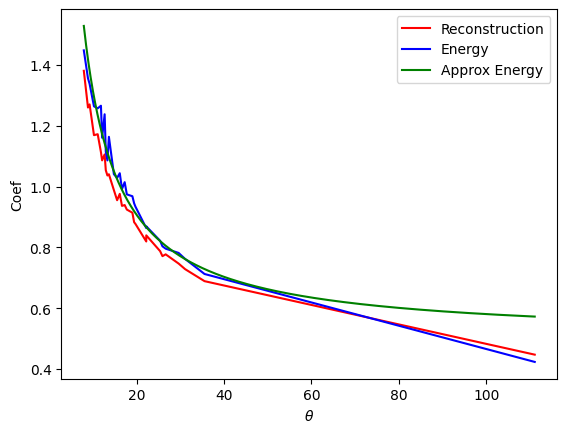

In [311]:

plt.plot(result_rec[:,0], result_rec[:,1], 'r', label = 'Reconstruction')
plt.plot(result_energy[:,0], result_energy[:,1], 'b', label = 'Energy')
plt.plot(aprox_range, aprox, 'g', label = 'Approx Energy')
# plt.plot(aprox_range, np.median(theta_pca)/aprox_range, 'y', label = 'Median')
plt.xlabel('$\\theta$')
plt.ylabel('Coef')
plt.legend()

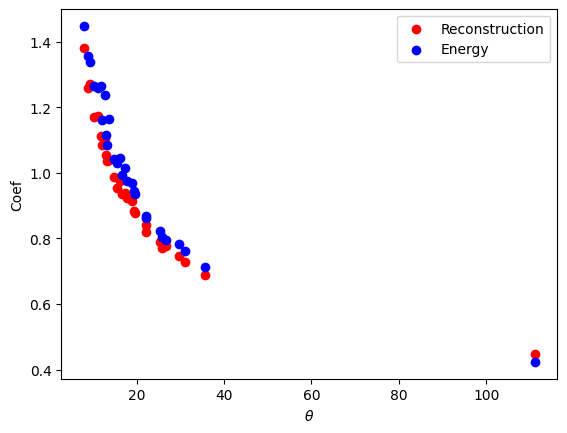

In [198]:
plt.scatter(result_rec[:,0], result_rec[:,1], c='r', label = 'Reconstruction')
plt.scatter(result_energy[:,0], result_energy[:,1], c='b', label = 'Energy')
plt.xlabel('$\\theta$')
plt.ylabel('Coef')
plt.legend()

In [100]:
theta_pca.mean()/theta_data.mean()

0.4973303641135113

In [108]:
n = np.inf
theta_pca.mean(),theta_data.mean(),  np.linalg.norm(theta_pca.flatten(),n),np.linalg.norm(theta_data.flatten(),n)

(17.68288099986433, 35.555603, 35.5556, 35.555603)

In [99]:
n = 0
scale = np.linalg.norm(theta_pca.flatten(),n)/np.linalg.norm(theta_data.flatten(),n)
print(scale)
scale = np.power(scale,0.25)
scale

9.0


1.7320508075688772

In [131]:
n = np.inf
scale = np.linalg.norm(theta_pca.flatten()**.5/theta_data[0,0]**.5,n)
scale

0.9999999574280345

In [110]:
scale = np.sqrt(theta_pca.mean()/theta_data[0,0])
scale

0.7052165370391645

In [94]:
elastic_oldroyd_fixed, kinetic_oldroyd_fixed, total_oldroyd_fixed = calc_energy(X_oldroyd,Wi,beta,Re,dx = DX[:,None], dy = DY[:,None])

In [95]:
# elastic_oldroyd_fixed, kinetic_oldroyd_fixed, total_oldroyd_fixed = calc_energy(X_oldroyd,Wi,beta,Re,dx = DX[:,None], dy = DY[:,None])
# scale,_,_,_ = np.linalg.lstsq(X_oldroyd.flatten()[:, None],X.flatten(), rcond=-1) # better fit the reconstruction
scale,_,_,_ = np.linalg.lstsq(total_oldroyd_fixed.flatten()[:, None],total.flatten(), rcond=-1) # better fit the energy
scale_2 = scale
scale = np.sqrt(scale)
scale,scale_2

(array([0.71258539]), array([0.50777793]))

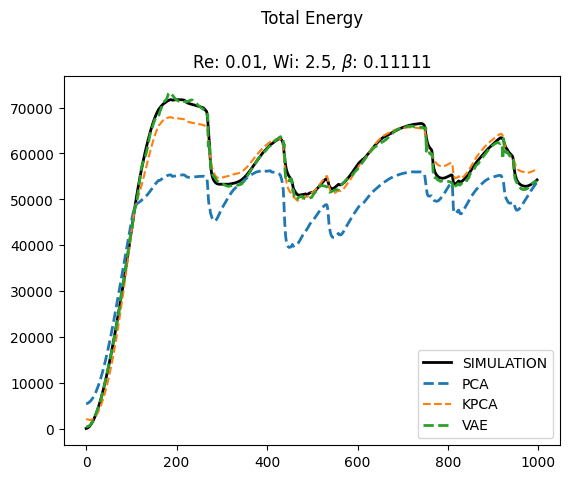

In [96]:
# Energy From data
elastic, kinetic, total = calc_energy(X,Wi,beta,Re, dx = DX[:,None], dy = DY[:,None])

# # Energy From Autoencoder
elastic_ae, kinetic_ae, total_ae = calc_energy(X_ae,Wi,beta,Re,dx = DX[:,None], dy = DY[:,None])

# Energy From PCA
elastic_linear, kinetic_linear, total_linear = calc_energy(X_linear,Wi,beta,Re,dx = DX[:,None], dy = DY[:,None])
# Energy From KPCA
elastic_oldroyd, kinetic_oldroyd, total_oldroyd = calc_energy(X_oldroyd*scale,Wi,beta,Re,dx = DX[:,None], dy = DY[:,None])
# elastic_oldroyd_2, kinetic_oldroyd_2, total_oldroyd_2 = calc_energy(X_oldroyd *tsm/theta_data[0,0],Wi,beta,Re,dx = DX[:,None], dy = DY[:,None])

ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)

plt.plot(total_linear[ini:fim],'--', label = 'PCA', lw = lw)
plt.plot(total_oldroyd[ini:fim],'--', label = 'KPCA')
# plt.plot(total_oldroyd_fixed[ini:fim]*scale_2,linestyle='dotted', label = 'KPCA 2')

plt.plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
plt.title(f'Total Energy\n\nRe: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()

# plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

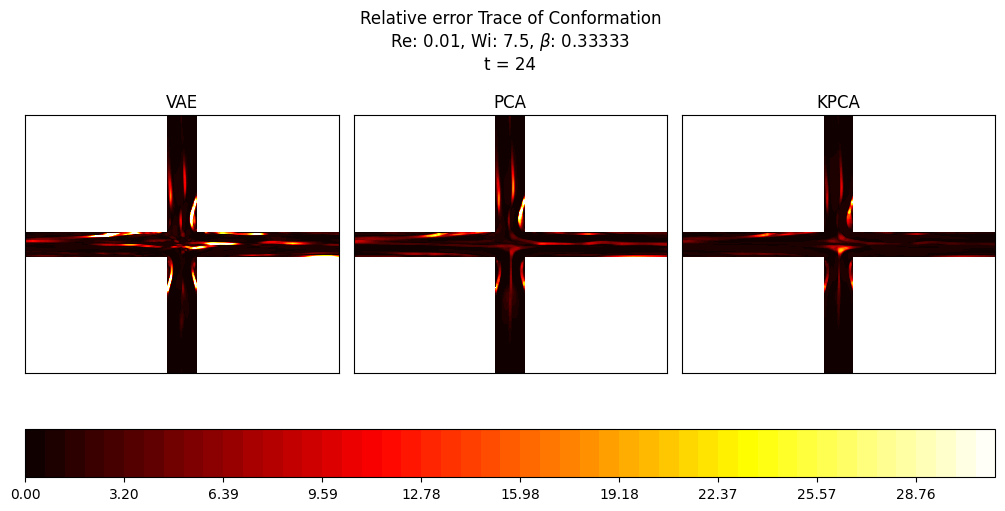

In [157]:
t = 600
cmap = 'hot'
err_ae = np.abs((tra_At[...,t] - tra_Ar[...,t]) / tra_At[...,t])
err_lin = np.abs((tra_At[...,t] - tra_Ar_lin[...,t]) /tra_At[...,t] )
err_old = np.abs((tra_At[...,t] - tra_Ar_old[...,t]) / tra_At[...,t])

vmin = np.min([np.nanmin(err_ae), np.nanmin(err_lin), np.nanmin(err_old)])
vmax = np.min([np.nanmax(err_ae), np.nanmax(err_lin), np.nanmax(err_old)])

levels = np.linspace(vmin, vmax, 50)
f, ax = plt.subplots(1,3, figsize = (10,5))

ax[0].contourf(Xr_mesh,Yr_mesh,err_ae, levels=levels, cmap=cmap)
ax[1].contourf(Xr_mesh,Yr_mesh,err_lin, levels=levels, cmap=cmap)
surf = ax[2].contourf(Xr_mesh,Yr_mesh,err_old, levels=levels, cmap=cmap)

f.suptitle(f'Relative error Trace of Conformation\nRe: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}\nt = {t*4e-2:g}')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].set_xticks([])
ax[2].set_yticks([])

ax[0].set_title('VAE')
ax[1].set_title('PCA')
ax[2].set_title('KPCA')

f.tight_layout()
plt.colorbar(surf, ax = ax, location='bottom')


Text(0.5, 1.0, 'Dataset parameters distribuition')

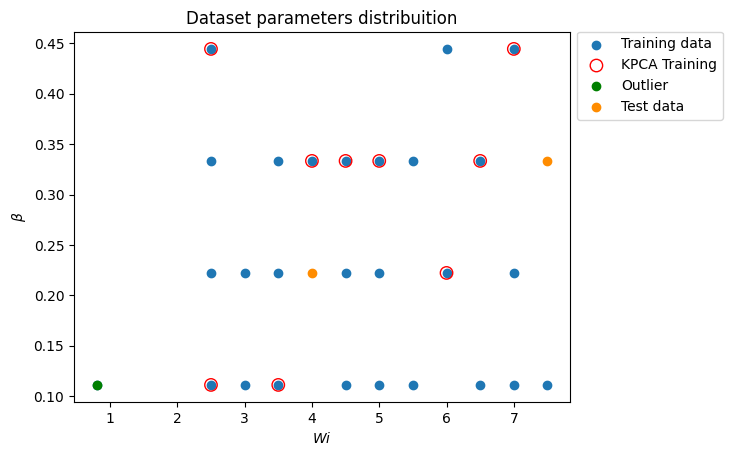

In [179]:
arr_p = np.array(parameters)
step = 3
init = 1
plt.scatter(arr_p[:-2,0],arr_p[:-2,1], label = 'Training data')
# plt.plot(arr_p[init:-2:step,0],arr_p[init:-2:step,1], 'ms', label = 'KPCA\nTraining')
plt.scatter(arr_p[init:-2:step,0],arr_p[init:-2:step,1], s=80, facecolors='none', edgecolors='r',label = 'KPCA Training')
plt.scatter(arr_p[0,0],arr_p[0,1], c='g', label = 'Outlier')
plt.scatter(arr_p[-2:,0],arr_p[-2:,1], c='darkorange', label = 'Test data')

plt.ylabel('$\\beta$')
plt.xlabel('$Wi$')
plt.legend(bbox_to_anchor=(1., 1.02))
plt.title('Dataset parameters distribuition')

In [15]:
K = KPCA_oldroyd.K_fit
K_row = K.mean(0)
K_col = K.mean(1)[:,None]
K_all = K.mean()
Kc = K -K_row - K_col + K_all

Z = Kc @KPCA_oldroyd.normalized_eigenvector

In [16]:
Xo = KPCA_oldroyd.invert_transform(Z)

In [17]:
x = np.linalg.lstsq(Xo.flatten()[:, None], Xpca.flatten(),None)[0]
x

array([1.])

In [52]:
code.shape

torch.Size([999, 3])

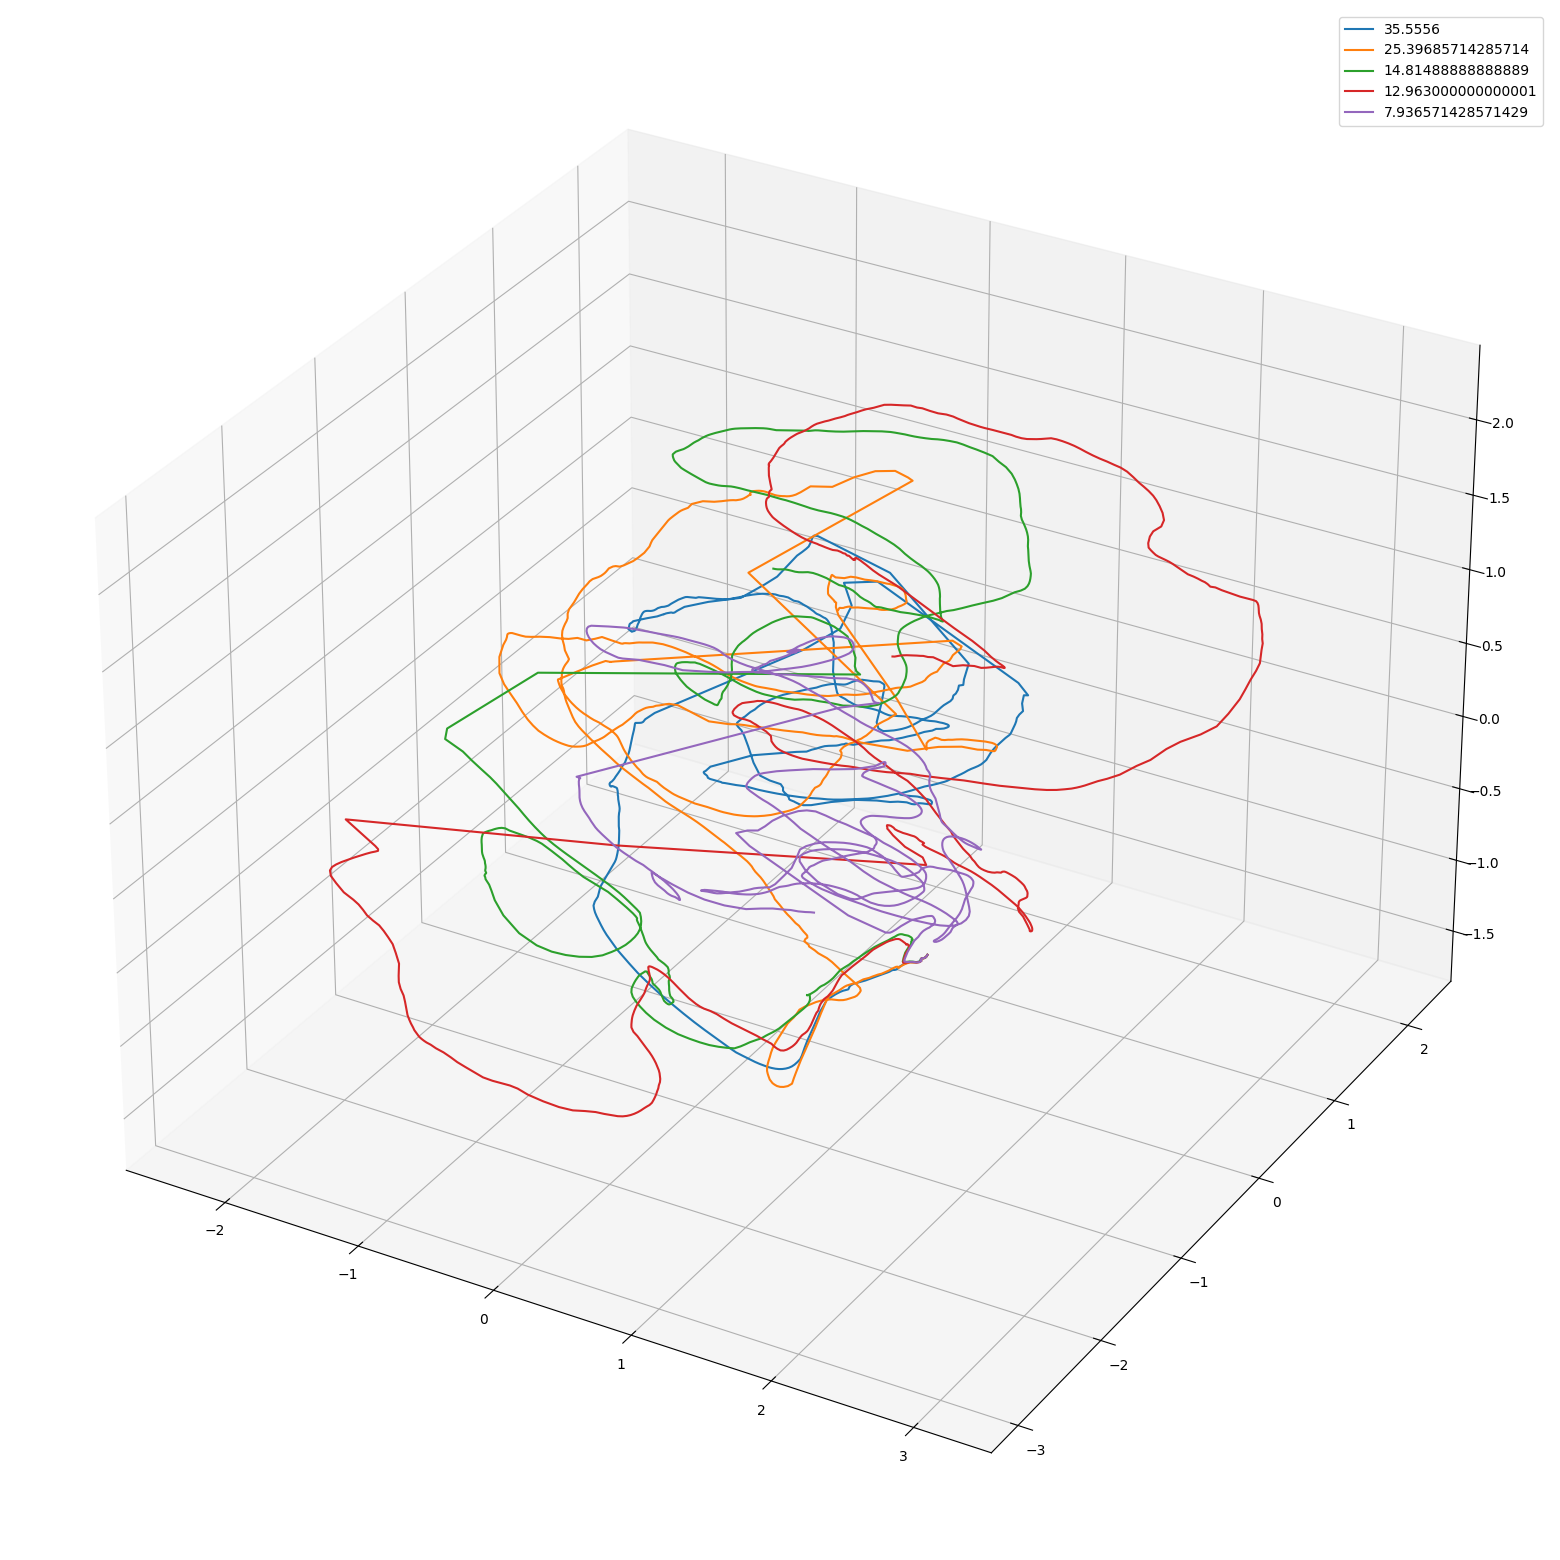

In [62]:
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(111, projection="3d")
## Data reading
for ind in range(1,29,6):
    Wi ,beta = parameters[ind]
    params = [Wi, beta]

    if (ind < 0 and ind > -3) or ind > 26:
        dspath = '../npz_data/crossTurb_test'
    else:
        dspath = '../npz_data/crossTurb_train'

    X_torch = read_from_ds(*params, ds_path=dspath)

    with torch.no_grad():
        code, u, s = autoencoder.encode(X_torch, param)

    i = 0

    z = u.numpy()
    theta = (1-beta)/(Re*Wi)
    ax1.plot(z[:,0], z[:,1], z[:,2], label = theta)
plt.legend()

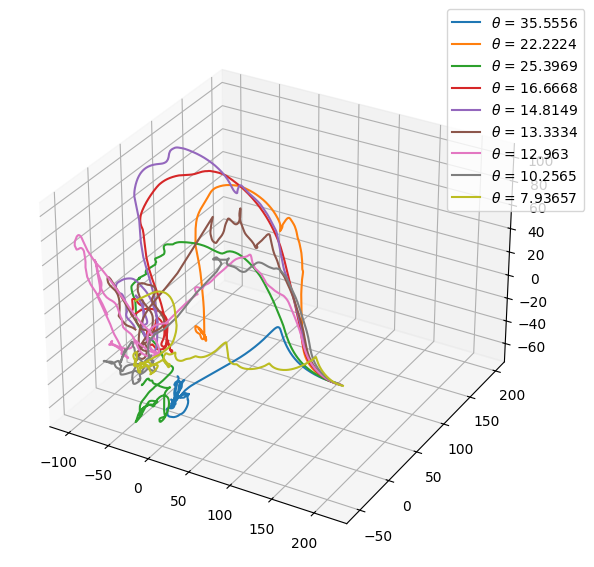

In [32]:
M = Z.shape[0]//999
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(121, projection="3d")
start_point = 0
for i in range(M):
    z = Z[i*999:(i+1)*999]

    ax1.plot(z[start_point:,0], z[start_point:,1], z[start_point:,2], label = f'$\\theta$ = {theta_pca[i*999,0]:g}')
    
ax1.legend(bbox_to_anchor=(1.1, 1.05))

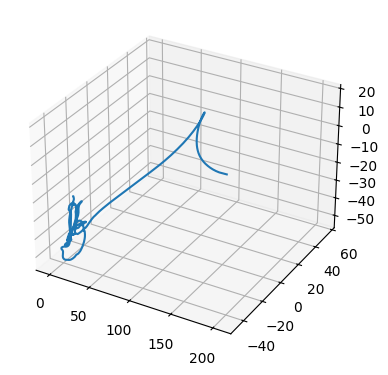

In [24]:
fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection="3d")
i = 0

z = Z[i*999:(i+1)*999]
ax1.plot(z[:,0], z[:,1], z[:,2], label = theta_pca[i*999,0])

In [327]:
ref_cases = [
    [10, 10, .9, 100],
    [10,5 ,.5 ,100],
    [1e-3, 5, .5 ,100],
    [1e-3,.5 ,.5 ,100],
]

Xpca = np.zeros((32000,0))
Parampca = np.zeros((0,3))
for Re, Wi, beta, ndata in ref_cases:
# for i in [1,2, 4]:
    param_temp = np.array([[Re, Wi, beta]])
    in_filename = f"../npz_data/cavitytransU80_data_Re{Re:g}_Wi{Wi:g}_beta{beta:g}.npz" # u,v,B
    
    fields = np.load(in_filename, allow_pickle=True)["fields"].item()
    u = fields["vel-u"]
    v = fields["vel-v"]
    Bxx = fields["Bxx"]
    Bxy = fields["Bxy"]
    Byy = fields["Byy"]
    q = np.stack((u,v,Bxx, Bxy, Byy), axis=-1)

    TU = q[:,:,:,0].reshape((q.shape[0]**2, q.shape[2]))
    TV = q[:,:,:,1].reshape((q.shape[0]**2, q.shape[2]))
    T11 = q[:,:,:,2].reshape((q.shape[0]**2, q.shape[2]))
    T12 = q[:,:,:,3].reshape((q.shape[0]**2, q.shape[2]))
    T22 = q[:,:,:,4].reshape((q.shape[0]**2, q.shape[2]))
    T = np.concatenate((TU, TV, T11,T12,T22), axis=1).reshape(-1, q.shape[2]) # by column axis=1(intercal..), by row axis=0

    Xt = T[:,1:ndata + 1]

    ones = np.ones((Xt.shape[1],3))
    Xpca = np.concatenate((Xpca,Xt), axis=1)
    Parampca = np.concatenate((Parampca,ones*param_temp), axis=0)

print("Train PCA Shape",Xpca.shape)
print('Params Train Shape',Parampca.shape)
print('Training indexes:', [i for i in training_index])

Re_arr = Parampca[:,0]
Wi_arr = Parampca[:,1]
beta_arr = Parampca[:,2]

theta_pca = ((1-beta_arr)/(Re_arr * Wi_arr))[:,None]
theta_pca_sqrt = np.sqrt(theta_pca@theta_pca.T)

print('Theta Shape',theta_pca.shape)
print('Theta train Shape',theta_pca_sqrt.shape)
# in_filename = f"npz_data/cavitytransU80_data_Re{Re:g}_Wi{Wi:g}_beta{beta:g}.npz" # u,v,B

dx = 0.0125
dy = dx

Train PCA Shape (32000, 400)
Params Train Shape (400, 3)
Training indexes: [1, 4, 7, 10, 13, 16, 19, 22, 25]
Theta Shape (400, 1)
Theta train Shape (400, 400)


In [295]:
Xpca = np.zeros((66045,0))
Parampca = np.zeros((0,2))
training_index = range(1,27,3)
Re = 0.01
for i in [1,9,17,25]:
# for i in [1,2, 4]:
    Wi_temp ,beta_temp = parameters[i]
    params_temp = np.array([Wi_temp, beta_temp])

    X_temp = read_from_ds(*params_temp, ds_path='../npz_data/crossTurb_train')
    Xt = torch2np(X_temp)
    param_temp = np.zeros((X_temp.shape[0], 2))
    param_temp[:] = params_temp

    Xpca = np.concatenate((Xpca,Xt), axis=1)
    Parampca = np.concatenate((Parampca,param_temp), axis=0)
    print(((1-beta_temp)/(Re * Wi_temp)))
print("Train PCA Shape",Xpca.shape)
print('Params Train Shape',Parampca.shape)
print('Training indexes:', [i for i in training_index])

Wi_arr = Parampca[:,0]
beta_arr = Parampca[:,1]

theta_pca = ((1-beta_arr)/(Re * Wi_arr))[:,None]
theta_pca_sqrt = np.sqrt(theta_pca@theta_pca.T)

print('Theta Shape',theta_pca.shape)
print('Theta train Shape',theta_pca_sqrt.shape)

dx = DX[None,:]
dy = DY[None,:]

35.5556
19.047714285714285
16.16163636363636
7.936571428571429
Train PCA Shape (66045, 3996)
Params Train Shape (3996, 2)
Training indexes: [1, 4, 7, 10, 13, 16, 19, 22, 25]
Theta Shape (3996, 1)
Theta train Shape (3996, 3996)


In [328]:
degree = 1
ncomp = latent_dim 

KPCA_linear = KPCA.KernelPCA()
KPCA_oldroyd = KPCA.KernelPCA()

KPCA_linear.fit(Xpca.T, n_components=ncomp, kernel='linear', theta=theta_pca_sqrt, norm='DIV', eps = None, degree = degree)
KPCA_oldroyd.fit(Xpca.T, n_components=ncomp, kernel='oldroyd', theta=theta_pca_sqrt, norm='DIV', eps = None, dx = dx, dy = dy, degree = degree)


In [329]:

Z_linear = KPCA_linear.transform(Xpca.T, theta_pca, dx = dx, dy = dy)
Z_oldroyd = KPCA_oldroyd.transform(Xpca.T, theta_pca_sqrt, dx = dx, dy = dy)

In [330]:
Xo_linear = KPCA_linear.invert_transform(Z_linear)
Xo_oldroyd = KPCA_oldroyd.invert_transform(Z_oldroyd)

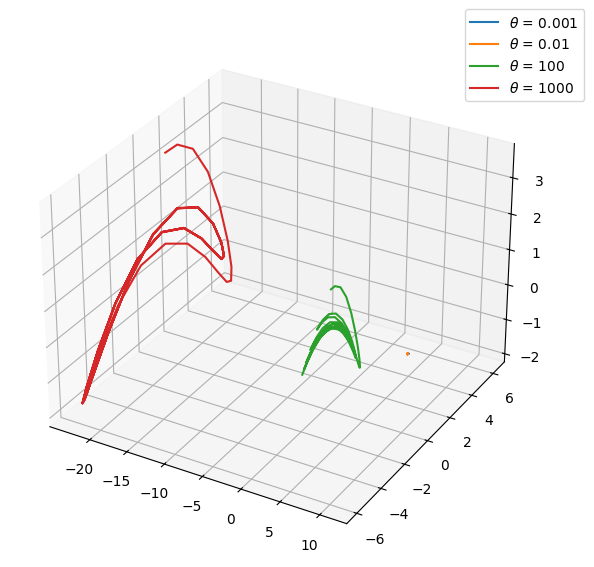

<Figure size 640x480 with 0 Axes>

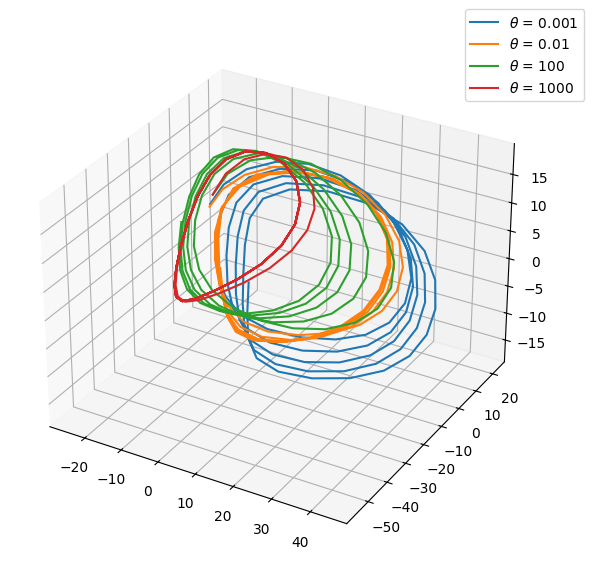

In [331]:
M = Z_linear.shape[0]//Xt.shape[1]
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(121, projection="3d")
start_point = 0
ndata = Xt.shape[1]
for i in range(M):
# for i in [3]:
    z = Z_oldroyd[i*Xt.shape[1]:(i+1)*Xt.shape[1]]
    ax1.plot(z[start_point:,0], z[start_point:,1], z[start_point:,2], label = f'$\\theta$ = {theta_pca[i*Xt.shape[1],0]:g}')
    
ax1.legend(bbox_to_anchor=(1.1, 1.05))

plt.figure()
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(121, projection="3d")
start_point = 0
ndata = Xt.shape[1]
for i in range(M):
# for i in [3]:
    z = Z_linear[i*Xt.shape[1]:(i+1)*Xt.shape[1]]
    ax1.plot(z[start_point:,0], z[start_point:,1], z[start_point:,2], label = f'$\\theta$ = {theta_pca[i*Xt.shape[1],0]:g}')
    
ax1.legend(bbox_to_anchor=(1.1, 1.05))

(8.888933, 0.33540935127704613)

In [339]:
i = 3
# Energy From data
elastic, kinetic, total = calc_energy(Xpca[..., i*ndata:(i+1)*ndata],Wi_arr[i*ndata],beta_arr[i*ndata],Re_arr[i*ndata], dx =dx, dy =dy)


# Energy From PCA
elastic_linear, kinetic_linear, total_linear = calc_energy(Xo_linear[..., i*ndata:(i+1)*ndata],Wi_arr[i*ndata],beta_arr[i*ndata],Re_arr[i*ndata],dx =dx, dy =dx)
# Energy From KPCA
elastic_oldroyd, kinetic_oldroyd, total_oldroyd = calc_energy(Xo_oldroyd[..., i*ndata:(i+1)*ndata],Wi_arr[i*ndata],beta_arr[i*ndata],Re_arr[i*ndata],dx =dx, dy =dx)
# elastic_oldroyd_2, kinetic_oldroyd_2, total_oldroyd_2 = calc_energy(X_oldroyd_2,Wi,beta,Re,dx = DX[:,None], dy = DY[:,None])

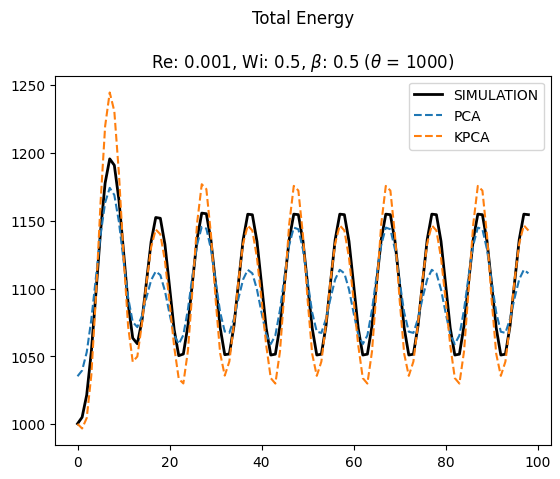

In [340]:
ini = 0
fim = -1
lw = 2
plt.figure()
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)

plt.plot(total_linear[ini:fim],'--', label = 'PCA')
plt.plot(total_oldroyd[ini:fim],'--', label = 'KPCA')

plt.title(f'Total Energy\n\nRe: {Re_arr[i*ndata]:g}, Wi: {Wi_arr[i*ndata]:g}, $\\beta$: {beta_arr[i*ndata]:g} ($\\theta$ = {theta_pca[i*ndata,0]:g})')
# plt.title(f'Total Energy\n\nRe: {Re:g}, Wi: {Wi_arr[i*ndata]:g}, $\\beta$: {beta_arr[i*ndata]:g} ($\\theta$ = {theta_pca[i*ndata,0]:g})')
plt.legend()


In [324]:
# %matplotlib widget
%matplotlib inline

In [192]:
def DQ(x,y, UNovo, VNovo):
    Nx = len(x)-1
    Ny = len(y)-1


    dx = x[1:] - x[:-1]
    dy = y[1:] - y[:-1]
    xc = (x[:-1] + x[1:]) * 0.5
    yc = (y[:-1] + y[1:]) * 0.5
    minDxDy = min(dx) * min(dy)
    x1 = y1 = 10
    x2 = y2 = 11

    streamline = np.zeros((Nx, Ny))
    DQ = 0.0

    pts = 0  # number of points away from inflow and outflow (I will leave it fixed for any cross-slot dimension)

    # Boundary conditions for Psi (streamline)

    # determining the indices
    i1 = next(i for i in range(Nx+1) if abs(xc[i]+dx[i]*.5 - x1) < 1e-8)+1

    i3 = next(i for i in range(i1, Nx+1) if abs(xc[i]-dx[i]*.5 - x2) < 1e-8)-1

    j1 = next(j for j in range(Ny+1) if abs(yc[j]+dy[j]*.5 - y1) < 1e-8)+1
    
    j3 = next(j for j in range(j1, Ny+1) if abs(yc[j]-dy[j]*.5 - y2) < 1e-8)-1
    


    # Block III
    for j in range(pts, j1):
        # v1 = VNovo[i1-1,j]
        # v2 = VNovo[i1,j]
        # v3 = VNovo[i1-1,j+1]
        # v4 = VNovo[i1,j+1]
        streamline[i1,j] = -minDxDy * VNovo[i1,j]

    # Block I
    for i in range(pts, i1):
        # u1 = UNovo[i,j1-1]
        # u2 = UNovo[i,j1]
        # u3 = UNovo[i+1,j1-1]
        # u4 = UNovo[i+1,j1]
        streamline[i,j1] = minDxDy * UNovo[i,j1]

    # Block IV
    for j in range(j3, Ny-pts):
        # v1 = VNovo[i3-1,j]
        # v2 = VNovo[i3,j]
        # v3 = VNovo[i3-1,j+1]
        # v4 = VNovo[i3,j+1]
        streamline[i3,j] = minDxDy * VNovo[i3,j]

    # Block V
    for i in range(i3, Nx-pts):
        # u1 = UNovo[i,j3-1]
        # u2 = UNovo[i,j3]
        # u3 = UNovo[i+1,j3-1]
        # u4 = UNovo[i+1,j3]
        streamline[i,j3] = -minDxDy * UNovo[i,j3]

    # Psi calculation

    # Block I
    for j in range(j1+1, j3+1):
        for i in range(pts, i1):
            # u1 = UNovo[i,j-1]
            # u2 = UNovo[i,j]
            # u3 = UNovo[i+1,j-1]
            # u4 = UNovo[i+1,j]
            streamline[i,j] = streamline[i,j-1] + 0.5 * (dy[j] + dy[j-1]) * UNovo[i,j]

    # Block III
    for i in range(i1+1, i3+1):
        for j in range(pts, j1):
            # v1 = VNovo[i-1,j]
            # v2 = VNovo[i,j]
            # v3 = VNovo[i-1,j+1]
            # v4 = VNovo[i,j+1]
            streamline[i,j] = streamline[i-1,j] - 0.5 * (dx[i] + dx[i-1]) * VNovo[i,j]

    # Block IV
    for i in range(i3-1, i1-1, -1):
        for j in range(j3+1, Ny-pts):
            # v1 = VNovo[i-1,j]
            # v2 = VNovo[i,j]
            # v3 = VNovo[i-1,j+1]
            # v4 = VNovo[i,j+1]
            streamline[i,j] = streamline[i+1,j] + 0.5 * (dx[i+1] + dx[i]) * VNovo[i,j]

    # Block V
    for j in range(j3, j1-1, -1):
        for i in range(i3+1, Nx-pts):
            # u1 = UNovo[i,j-1]
            # u2 = UNovo[i,j]
            # u3 = UNovo[i+1,j-1]
            # u4 = UNovo[i+1,j]
            streamline[i,j] = streamline[i,j+1] - 0.5 * (dy[j+1] + dy[j]) * UNovo[i,j]

    # Block II - central region, uniform mesh
    for j in range(j1, j3+1):
        for i in range(i1, i3+1):
            # u1 = UNovo[i,j-1]
            # u2 = UNovo[i,j]
            # u3 = UNovo[i+1,j-1]
            # u4 = UNovo[i+1,j]
            streamline[i,j] = streamline[i,j-1] + minDxDy *  UNovo[i,j]

    # Determining the central point of the cross-slot
    icentral = Nx // 2
    jcentral = Ny // 2

    DQ = 2.0 * streamline[icentral,jcentral] - 1.0

    return DQ, streamline

In [190]:
dq_true = np.zeros(X_true.shape[-1])
dq_rec = np.zeros(X_true.shape[-1])
dq_linear = np.zeros(X_true.shape[-1])
dq_oldroyd = np.zeros(X_true.shape[-1])
for t in range(X_true.shape[-1]):
    dq_true[t],_ = DQ(x[cut:-cut],y[cut:-cut], X_true[...,0,t], X_true[...,1,t])
    dq_rec[t],_ = DQ(x[cut:-cut],y[cut:-cut], X_rec[...,0,t], X_rec[...,1,t])
    dq_linear[t],_ = DQ(x[cut:-cut],y[cut:-cut], X_rec_lin[...,0,t], X_rec_lin[...,1,t])
    dq_oldroyd[t],_ = DQ(x[cut:-cut],y[cut:-cut], X_rec_old[...,0,t], X_rec_old[...,1,t])


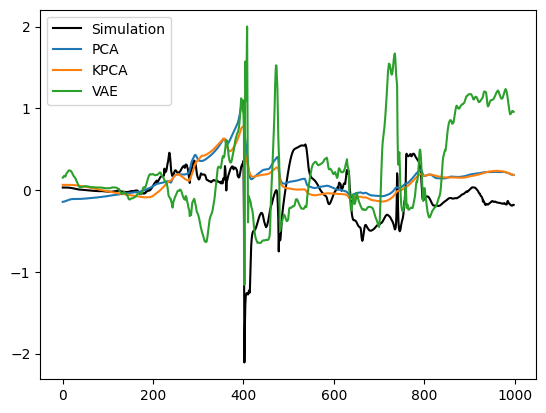

In [191]:
plt.plot(dq_true, 'k', label = 'Simulation')
plt.plot(dq_linear, label = 'PCA')
plt.plot(dq_oldroyd, label = 'KPCA')
plt.plot(dq_rec, label = 'VAE')

plt.legend()

In [109]:
t = 500
dq_t, sl = DQ(x[cut:-cut],y[cut:-cut], X_true[...,0,t], X_true[...,1,t])

In [187]:
sl[:65-cut,:65-cut] = np.NaN
sl[-65+cut:,:65-cut] = np.NaN
sl[:65-cut,-65+cut:] = np.NaN
sl[-65+cut:,-65+cut:] = np.NaN

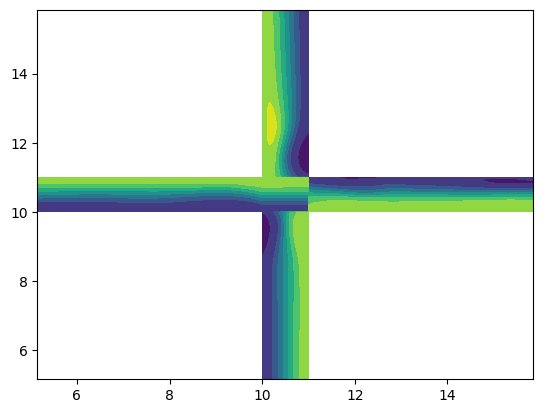

In [188]:
plt.contourf(Xr_mesh,Yr_mesh,sl)

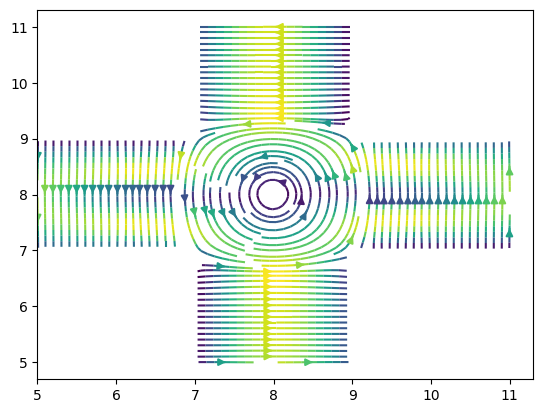

In [166]:
t = 100
speed = np.sqrt(X_true[...,0,t]**2 + X_true[...,1,t]**2)
plt.streamplot(np.linspace(5,11,155),np.linspace(5,11,155), X_true[...,0,t], X_true[...,1,t], color = speed, density = 2)

In [ ]:
## Data reading
ind = -1
Wi ,beta = parameters[ind]
params = [Wi, beta]

if (ind < 0 and ind > -3) or ind > 26:
    dspath = '../npz_data/crossTurb_test'
else:
    dspath = '../npz_data/crossTurb_train'

X_torch = read_from_ds(*params, ds_path=dspath)
X = torch2np(X_torch)
param = torch.ones((X_torch.shape[0], 2)).float()
param[:] = torch.Tensor(params).float()


Wi_data = param[:,0].numpy()
beta_data = param[:,1].numpy()

theta_data = ((1-beta_data)/(Re * Wi_data))[:,None]

print('Data shape: ',X.shape)
print('theta shape: ',theta_data.shape)
print('theta: ',theta_data[0])



In [41]:
# Run test
X_ae_split = np.zeros((latent_dim + 1,66045, 999))
with torch.no_grad():
    _, code, _ = autoencoder.encode(X_torch, param)
for lat_plot in range(latent_dim):
    with torch.no_grad():
        for i in range(latent_dim):
            code_split = torch.zeros_like(code)
            code_split[:, lat_plot] = code[:, lat_plot]
        X_ae_torch= autoencoder.decode(code_split, param)
        # X_ae_torch,_,_ = autoencoder(X_torch.float(), param.float())
    X_ae_split[lat_plot] = torch2np(X_ae_torch)
X_ae_torch= autoencoder.decode(code, param)
X_ae_split[-1] = torch2np(X_ae_torch)

In [43]:
## Visual Plots
X_ae_rec = np.zeros((latent_dim +1 , 155, 155, 5, 999))
for i in range(latent_dim+1):
    X_ae_rec[i] = reconstruct_cross(X_ae_split[i].reshape((-1,5,999)), cut)
X_ae_rec[:, :65-cut,:65-cut] = np.NaN
X_ae_rec[:, -65+cut:,:65-cut] = np.NaN
X_ae_rec[:, :65-cut,-65+cut:] = np.NaN
X_ae_rec[:, -65+cut:,-65+cut:] = np.NaN

X_true_rec = reconstruct_cross(X.reshape((-1,5,999)), cut)
X_true_rec[:65-cut,:65-cut] = np.NaN
X_true_rec[-65+cut:,:65-cut] = np.NaN
X_true_rec[:65-cut,-65+cut:] = np.NaN
X_true_rec[-65+cut:,-65+cut:] = np.NaN

In [45]:
X_ae_rec[:-1].sum(0).shape

(155, 155, 5, 999)

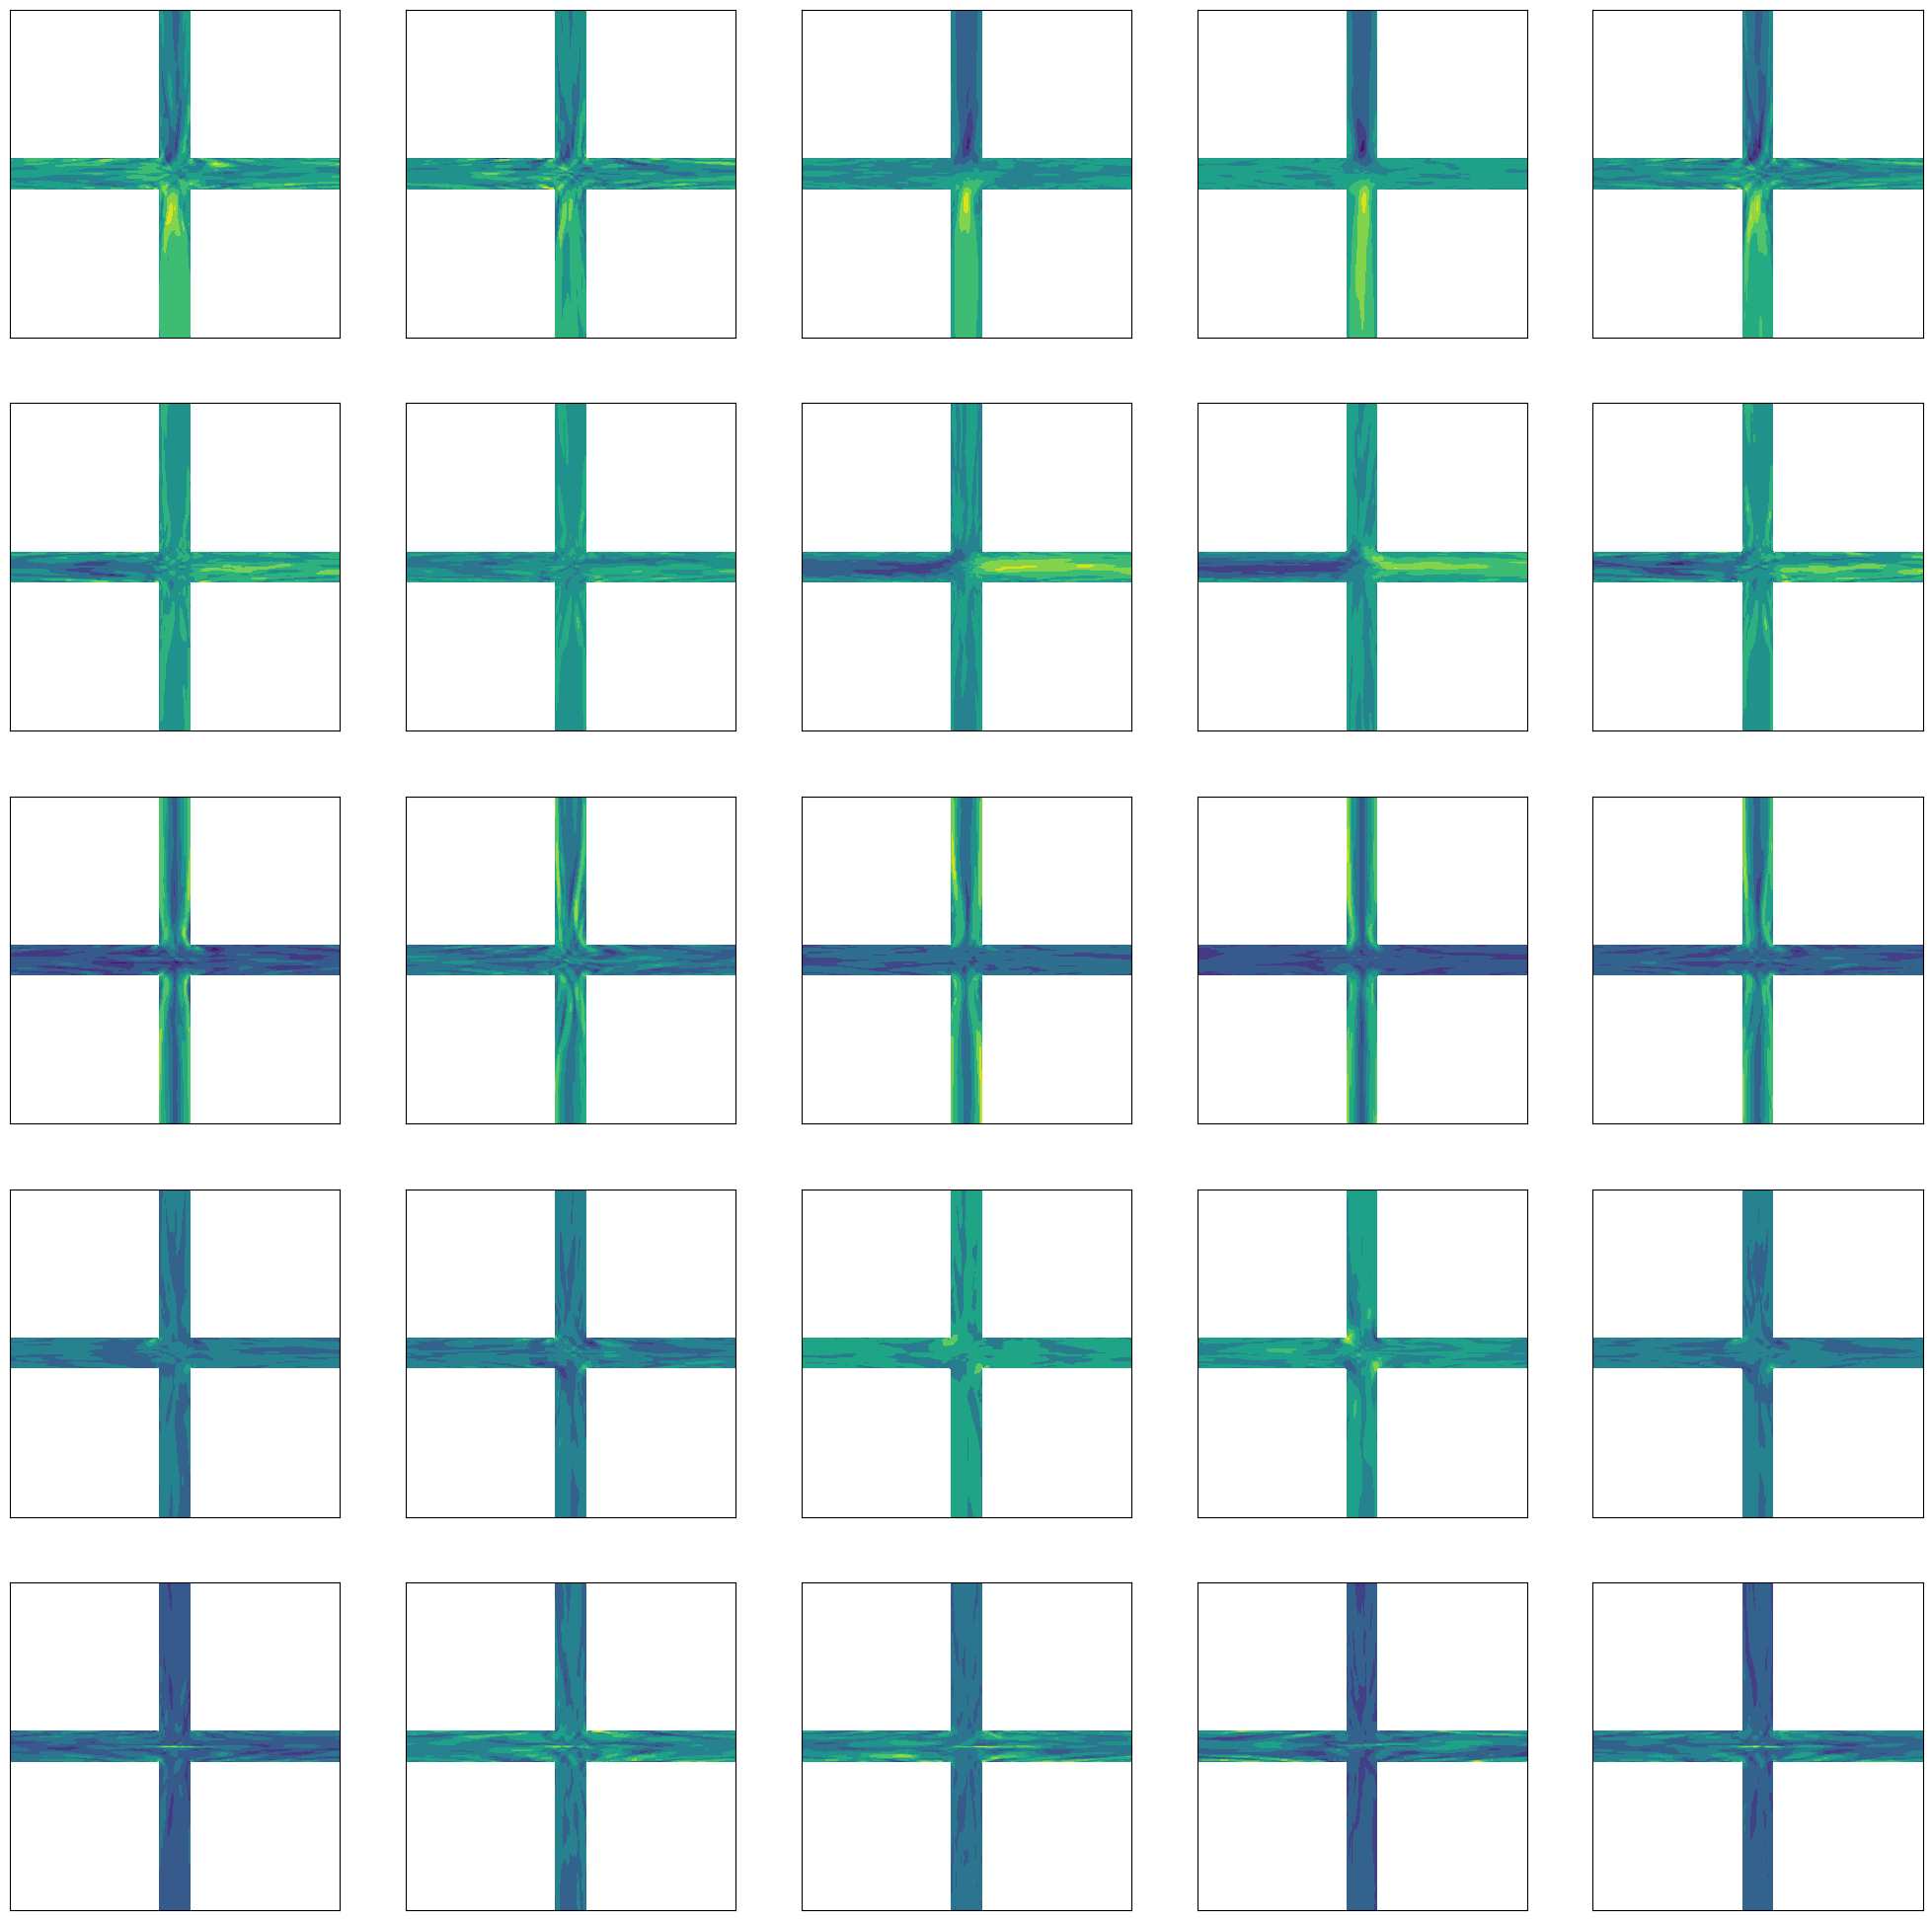

In [47]:
f, ax = plt.subplots(5,5, figsize = (25,25))
t = 500
for i in range(5):
    for j in range(5):

        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        if j < 4:
            ax[i,j].contourf(Xr_mesh,Yr_mesh,X_ae_rec[j,...,i, t])
        else:
            ax[i,j].contourf(Xr_mesh,Yr_mesh,X_ae_rec[:-1].sum(0)[...,i, t])

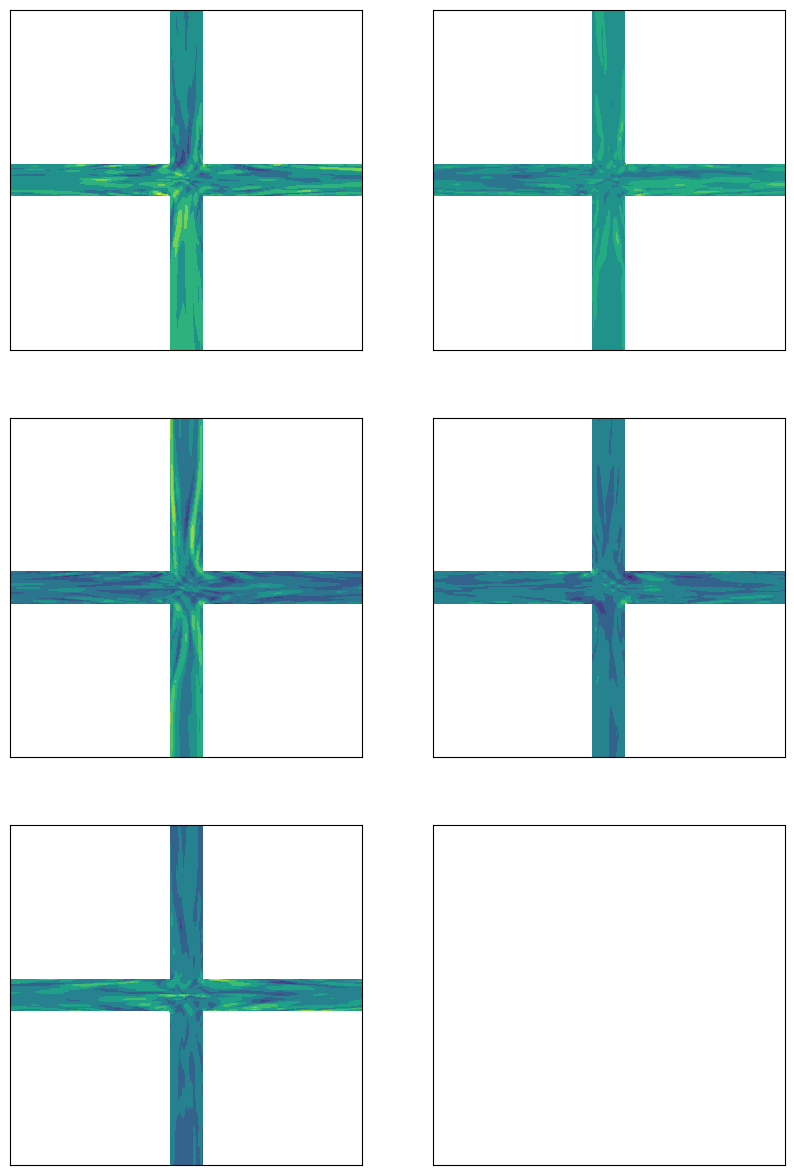

In [35]:
f, ax = plt.subplots(3,2, figsize = (10,15))
t = 500
for i in range(3):
    for j in range(2):
        k = i * 2 + j
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        if k >= 5:
            continue 
        ax[i,j].contourf(Xr_mesh,Yr_mesh,X_ae_rec[...,k, t])

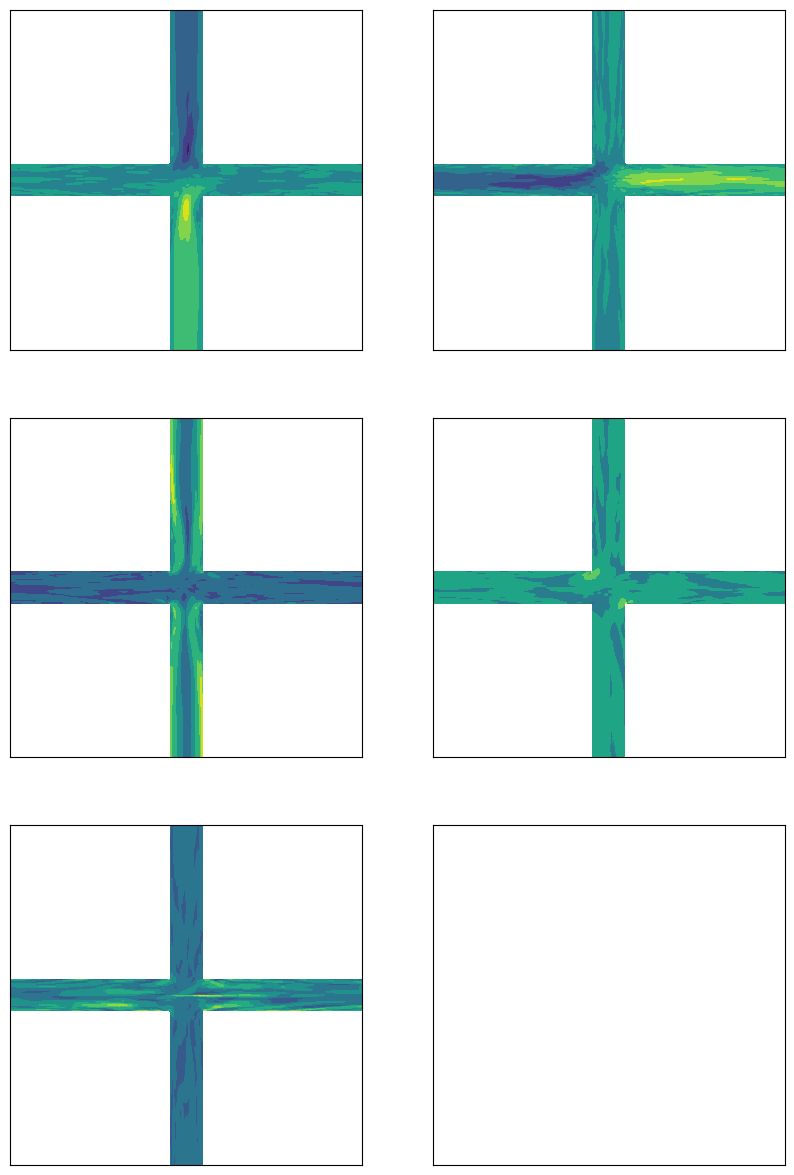

In [38]:
f, ax = plt.subplots(3,2, figsize = (10,15))
t = 500
for i in range(3):
    for j in range(2):
        k = i * 2 + j
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        if k >= 5:
            continue 
        ax[i,j].contourf(Xr_mesh,Yr_mesh,X_ae_rec[...,k, t])

In [ ]:
save_dir = f'Images/VAE_parametric_small/Wi_{Wi:g}_beta_{beta:g}/streamline'
os.makedirs(save_dir, exist_ok= True)
for t in range(X.shape[1]):
# for t in range(1):
    speed = np.sqrt(X_true[...,0,t]**2 + X_true[...,1,t]**2)
    plt.streamplot(np.linspace(5,11,155),np.linspace(5,11,155), X_true[...,0,t], X_true[...,1,t], color = speed, density = 2)
    vmin = np.min(speed)
    vmax = np.max(speed)
    f, ax = plt.subplots(1,1, figsize = (5,5))

    surf = ax.streamplot(np.linspace(5,11,155),np.linspace(5,11,155), X_true[...,0,t], X_true[...,1,t], color = speed, density = 2)


    ax.set_title('Simulation')
    # ax[1,0].set_title('PCA')

    # surf = ax[0,1].contourf(Xr_mesh,Yr_mesh,tra_Ar[...,t], levels=levels)
    # ax[1,1].contourf(Xr_mesh,Yr_mesh,tra_Ar_old[...,t], levels=levels)
    # ax[0,1].set_title('VAE')
    # ax[1,1].set_title('KPCA')
    f.suptitle(f'Trace of Conformation\nRe: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}\nt = {t*4e-2:g}')
    ax.set_xticks([])
    ax.set_yticks([])
    # ax[1,0].set_xticks([])
    # ax[1,0].set_yticks([])
    # ax[0,1].set_xticks([])
    # ax[1,1].set_xticks([])
    # ax[0,1].set_yticks([])
    # ax[1,1].set_yticks([])
    f.tight_layout()
    # plt.colorbar(surf, ax = ax, location='bottom')
    f.savefig(f'{save_dir}/frame_{t}.png')
    plt.close()

In [160]:
from scipy.interpolate import griddata

def streams(ax,xx,yy,u,v,method='linear'):
   x = np.linspace(xx.min(), xx.max(), 50)
   y = np.linspace(yy.min(), yy.max(), 50)

   xi, yi = np.meshgrid(x,y)

   #then, interpolate your data onto this grid:

   px = xx.flatten()
   py = yy.flatten()
   pu = u.flatten()
   pv = v.flatten()
   speed = np.sqrt((u**2)+(v**2))
   pspeed = speed.flatten()

   points = np.r_[ px[None,:], py[None,:]].T # The purpose of a[None,a] is to add an axis to array a

   gu = griddata(points, pu, (xi,yi),method=method)
   gv = griddata(points, pv, (xi,yi),method=method)
   gspeed = griddata(points, pspeed, (xi,yi),method=method)

   # lw = 2*gspeed/np.nanmax(gspeed)
   #now, you can use x, y, gu, gv and gspeed in streamplot:

   # if base_map:
   #    xx,yy = ax(xx,yy)
   #    xi,yi = ax(xi,yi)

   # ax.contour(xx,yy,speed, colors='k', alpha=0.4)
   # ax.plot(xx,yy,'-k',alpha=0.3)
   # ax.plot(xx.T,yy.T,'-k',alpha=0.3)
   # ax.plot(xi,yi,'-b',alpha=0.1)
   # ax.plot(xi.T,yi.T,'-b',alpha=0.1)
   c = ax.streamplot(x,y,gu,gv, density=2, color=gspeed, cmap=plt.cm.jet)

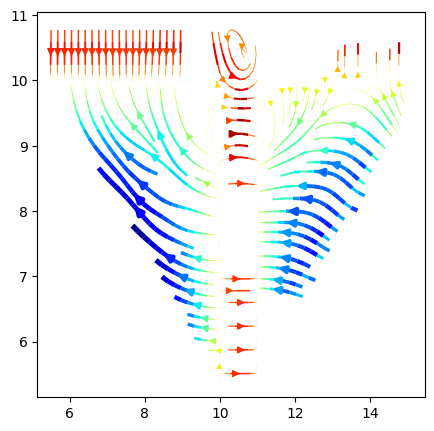

In [161]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
streams(ax, Xr_mesh,Yr_mesh, X_true[...,0,t], X_true[...,1,t], 'cubic')
